In [ ]:
import tensorflow as tf
import argparse
import json
import string
import os
import shutil
import uuid
from captcha.image import ImageCaptcha
import itertools
import os
import cv2
import numpy as np
from random import random, randint, choices
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, AveragePooling2D
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.model_selection import train_test_split
from IPython.display import display


In [2]:
#primary data set kaggle
    #use generated captcha as expriment for outside dataste testing
    #report only results
    #train the model twice, or freeze the layers and add new layers
    
#use categorical loss
#softmax
#different cnn models


In [3]:
# generated CAPTCHAs using Python ImageCaptcha Library
alphabet_all = list('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
#alphabet_all = list('qwertyupasdfghjkzxcvbnmo23456789QWERTYUPKJHGFDSAZXCVBNM')
alphabet = list('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
num_alphabet = len(alphabet)

def _gen_captcha(img_dir, num_of_letters, num_of_repetition, width, height):
    if os.path.exists(img_dir):
        shutil.rmtree(img_dir)
    if not os.path.exists(img_dir):
        os.makedirs(img_dir)
        
    image = ImageCaptcha(width=width, height=height)

    for counter in range(num_of_repetition):
        i = choices(alphabet_all, k=5)
        captcha = ''.join(i)
        fn = os.path.join(img_dir, '%s_%s.png' % (captcha, uuid.uuid4()))
        image.write(captcha, fn)

def gen_dataset(path, num_of_repetition, num_of_letters, width, height):
    _gen_captcha(os.path.join(path, 'data'), num_of_letters, num_of_repetition, width, height)
    print('Finished Data Generation')

In [4]:
BATCH_SIZE = (128*2)  #128
NUM_OF_LETTERS = 5
EPOCHS = 150
IMG_ROW, IMG_COLS = 50, 135
# Non-configs
PATH = os.getcwd() # get current path


In [5]:
# Save model and weights
def SaveModel(model, save_dir, model_name):
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    model.save(model_path)
    print('Saved trained model at %s ' % save_dir)

In [6]:
#pre-processing
def load_data(path,img_type,datasetSize=-1, test_split=0.1):
    print ('loading dataset...')
    y_train = []
    y_test = []
    x_train = []
    x_test = []
    list = os.listdir(path) # dir is your directory path
    number_files = len(list)
    print("Total number of files in folder: ", number_files)
    
    if((datasetSize == (-1)) or (datasetSize > number_files)):
        datasetSize = number_files
        
    print("Total number of requested files: ", datasetSize)


    
    # r=root, d=directories, f = files
    counter = 0
    for r, d, f in os.walk(path):
        for fl in f:
            if(counter < datasetSize):
                if '.'+ img_type in fl:
                    flr = fl.split('_')[0]
                    counter += 1
                    label = np.zeros((NUM_OF_LETTERS, num_alphabet))
                    for i in range(NUM_OF_LETTERS):
                        label[i, alphabet.index(flr[i].lower())] = 1
        #                 label = np.zeros((50, 1))
        #                 for i in range(5):
        #                     label[i*5+int(flr[i])] = 1
                        img = cv2.imread(os.path.join(r, fl))
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                        img = cv2.resize(img, (int(135/2), int(50/2)), interpolation=cv2.INTER_AREA)
                        img = np.reshape(img, (img.shape[0], img.shape[1], 1))
                  
                    if random() < test_split:
                        y_test.append(label)
                        x_test.append(img)
                    else:
                        y_train.append(label)
                        x_train.append(img)
            else: break;

    print('dataset size:', counter, '(train=%d, test=%d)' % (len(y_train), len(y_test)))
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

In [7]:
def EvaluateScore(model, xtrain, strain, xtest, stest):
    # Score trained model.
    scores = model.evaluate(xtrain, strain, verbose=1) #x_train, s_train
    print('Train loss:     %f' % np.mean(scores[0:5]))
    acc = 1.
    for i in range(5):
        acc *= scores[6+i]
    print('Train accuracy: %.2f' % (acc * 100.))
    scores = model.evaluate(xtest, stest, verbose=1)#x_test, s_test
    print('Test loss:     %f' % np.mean(scores[0:5]))
    acc = 1.
    for i in range(5):
        acc *= scores[6+i]
    print('Test accuracy: %.2f' % (acc * 100.))



In [8]:
def plot_diagram(digit_acc_now, val_digit_acc_now, loss_now, val_loss_now):
    global digit_acc, val_digit_acc, loss, val_loss
    
    digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
    val_digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
    loss = []
    val_loss = []
    
    for i in range(NUM_OF_LETTERS):
        digit_acc[i].extend(digit_acc_now[i])
        val_digit_acc[i].extend(val_digit_acc_now[i])
    loss.extend(loss_now)
    val_loss.extend(val_loss_now)
    
    for i in range(NUM_OF_LETTERS):
        s = {0:'First', 1:'Second', 2:'Third', 3:'Fourth', 4:'Fifth'}[i]
        # plt.plot(val_digit_acc[i], label='%s Digit Train' % s)
        plt.plot(digit_acc[i], label='%s Digit train' % s)

    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    for i in range(NUM_OF_LETTERS):
        s = {0:'First', 1:'Second', 2:'Third', 3:'Fourth', 4:'Fifth'}[i]
        plt.plot(val_digit_acc[i], label='%s Digit Val' % s)
        # plt.plot(digit_acc[i], label='%s Digit Test' % s)

    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # Plot training & validation loss values
    
    plt.plot(val_loss, label='vall')
    plt.plot(loss, label='train')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [9]:
def GetDataSet(path,image_type= 'png', size=-1):
    DATA_PATH = os.path.join(PATH, path)
    x_train, y_train, x_test, y_test = load_data(DATA_PATH, image_type, size)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    #normalise the data
    x_train /= 255
    x_test /= 255
    print(x_train.shape)
    print(y_train.shape)
    print(x_test.shape)
    print(y_test.shape)
    s_train = []
    s_test = []
    
    for i in range(NUM_OF_LETTERS):
        s_train.append(y_train[:, i, :])
        s_test.append(y_test[:, i, :])
        
    return x_train, y_train, x_test, y_test, s_train, s_test
    


    


    

In [89]:
def TrainModel(network, x_train, s_train, x_test, s_test, version ='' ,val_size=0.1, saveModel = True):
#     trainedModels = []
    (model, name) = network
        
    print("Total data set size: ", len(x_train) + len(x_test))
    print("Training size: ", len(x_train))
    print("Testing size: ", len(x_test))
    print("Validation size: " + str(val_size) + " of the training set")
    print("Number of epochs: ", EPOCHS)        
    print("Batch size: ", BATCH_SIZE)

    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

    model.summary()

    history = model.fit(x_train, s_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_split= val_size,
                    callbacks = [callback, printlr])
    finished_epochs =  len(history.history['loss'])
    print("Number of finished epochs: ", finished_epochs)
    
    #modelname, number of finished epochs and batch size
    save_dir = os.path.join(PATH, 'saved_models')
    name = name + '_' + str(finished_epochs) + '_' + str(BATCH_SIZE) +'_' +version +'.h5'
    SaveModel(model, save_dir, name)
          
    plot_diagram([history.history['digit%d_accuracy' % i] for i in range(NUM_OF_LETTERS)],
                 [history.history['val_digit%d_accuracy' % i] for i in range(NUM_OF_LETTERS)],
                 history.history['loss'],
                 history.history['val_loss'])
        
    EvaluateScore(model, x_train, s_train, x_test, s_test)
        

        
    
    return model, name, history
    
    




In [11]:
#datasets are local!
#Big generated dataset
x_trainBig, y_trainBig, x_testBig, y_testBig, s_trainBig, s_testBig = GetDataSet('train_big', 'png', 100000)

loading dataset...
Total number of files in folder:  1
Total number of requested files:  1
dataset size: 1 (train=1, test=0)
(1, 25, 67, 1)
(1, 5, 62)
(0,)
(0,)


IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

In [88]:
#generated dataset
x_trainGen, y_trainGen, x_testGen, y_testGen, s_trainGen, s_testGen = GetDataSet('train','png', 100000)

loading dataset...
Total number of files in folder:  113062
Total number of requested files:  100000
dataset size: 100000 (train=89954, test=10046)
(89954, 25, 67, 1)
(89954, 5, 62)
(10046, 25, 67, 1)
(10046, 5, 62)


In [12]:
#Kaggle dataset 113062
x_trainKaggle, y_trainKaggle, x_testKaggle, y_testKaggle, s_trainKaggle, s_testKaggle = GetDataSet( 'archive', 'jpg',100000)

loading dataset...
Total number of files in folder:  113062
Total number of requested files:  100000
dataset size: 100000 (train=90068, test=9932)
(90068, 25, 67, 1)
(90068, 5, 62)
(9932, 25, 67, 1)
(9932, 5, 62)


In [ ]:
#Generate Captcha labels
# DATA_PATH_Gen = os.path.join(PATH, 'train')# create new folder for data
# if not os.path.exists(DATA_PATH_Gen):
#     print('Generating Dataset')
#     gen_dataset(DATA_PATH_Gen,113062 , NUM_OF_LETTERS, IMG_COLS, IMG_ROW) #700*1000

In [12]:
save_dir = os.path.join(PATH, 'saved_models')


In [13]:
def ModelVGG19(input_shape):
    input_layer = Input(input_shape)
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(input_layer)
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(x)  
    x = MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(x) #strides= (2,2)
    
    x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(x) #strides= (2,2)

    x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(x) #strides= (2,2)

    x = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(x) #strides= (2,2)

    x = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same')(x) #strides= (2,2)

      
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    out = [Dense(num_alphabet, name='digit%d' % i, activation='softmax')(x) for i in range(NUM_OF_LETTERS)]
    # out = Dense(num_alphabet*5, activation='sigmoid')(x)

    model = Model(name ='VGG19',inputs=input_layer, outputs=out)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_name = 'keras_VGG19_trained_model'

    return model, model_name


In [14]:
#simplfied version 
def ModelVGG16(input_shape):
    
    input_tensor = Input(input_shape)
    x = input_tensor
    #32*2 = 64,32*4= 128,32*8=256, 32*16=512
    for i in range(4):
        x = Conv2D(filters=32*2**i, kernel_size=(3, 3),strides= 1, padding='same', activation='relu')(x)
        x = Conv2D(filters=32*2**i, kernel_size=(3, 3),strides= 1, padding='same', activation='relu')(x)
        x = MaxPooling2D(pool_size=(3, 3), strides = (2,2), padding = 'same')(x)
    #     x = Conv2D(filters= 32*2**i, kernel_size= (3, 3), activation='relu')(x)
    #     x = Conv2D(filters= 32*2**i, kernel_size= (3, 3), activation='relu')(x)

    x = Dropout(0.5)(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
#     x = Dense(4096, activation='relu')(x)
#     x = Dropout(0.5)(x)
    
    # x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(4)]
    out = [Dense(num_alphabet, name='digit%d' % i, activation='softmax')(x) for i in range(NUM_OF_LETTERS)]

    model = Model(name = 'VGG16_simplfied', inputs=input_tensor, outputs=out)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    model_name = 'keras_VGG16_trained_model'

    return model, model_name

In [15]:
#simplfied version 
def ModelVGG16complex(input_shape):
    
    input_tensor = Input(input_shape)
    x = input_tensor
    #32*2 = 64,32*4= 128,32*8=256, 32*16=512
    for i in range(4):
        x = Conv2D(filters=32*2**i, kernel_size=(3, 3),strides= 1, padding='same', activation='relu')(x)
        x = Conv2D(filters=32*2**i, kernel_size=(3, 3),strides= 1, padding='same', activation='relu')(x)
        x = MaxPooling2D(pool_size=(3, 3), strides = (2,2), padding = 'same')(x)
    #     x = Conv2D(filters= 32*2**i, kernel_size= (3, 3), activation='relu')(x)
    #     x = Conv2D(filters= 32*2**i, kernel_size= (3, 3), activation='relu')(x)

    x = Dropout(0.5)(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    # x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(4)]
    out = [Dense(num_alphabet, name='digit%d' % i, activation='softmax')(x) for i in range(NUM_OF_LETTERS)]

    model = Model(name = 'VGG16Complex', inputs=input_tensor, outputs=out)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    model_name = 'keras_VGG16Complex_trained_model'

    return model, model_name

In [16]:
#architecture
def ModelCifar10(input_shape):
    input_layer = Input(input_shape)

    x = Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu')(input_layer)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(filters=48, kernel_size=(5, 5), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    #num_alphabet: number of classes
    #name: name of the layer
    #activation: type
    #x input from the next layer
    #NUM_OF_LETTERS: 5 in an example
    out = [Dense(num_alphabet, name='digit%d' % i, activation='softmax')(x) for i in range(NUM_OF_LETTERS)]
    # out = Dense(num_alphabet*5, activation='sigmoid')(x)
    model_name = 'keras_Cifar10_trained_model'

    model = Model(name = 'BaseModel', inputs=input_layer, outputs=out)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


    return model, model_name


    

In [17]:
def ModelAlexnet(input_shape):
    input_layer = Input(input_shape)

    x = Conv2D(filters=96, kernel_size=(11, 11), strides= 4,  padding='same', activation='relu')(input_layer)
    x = MaxPooling2D(pool_size=(3, 3), strides = (2,2),  padding='same')(x)

    x = Conv2D(filters=256, kernel_size=(5, 5),strides= 1, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides = (2,2), padding = 'same')(x)

    x = Conv2D(filters=384, kernel_size=(3, 3),strides= 1, padding='same', activation='relu')(x)
    x = Conv2D(filters=384, kernel_size=(3, 3),strides= 1, padding='same', activation='relu')(x)
    x = Conv2D(filters=256, kernel_size=(3, 3),strides= 1, padding='same', activation='relu')(x)

    x = MaxPooling2D(pool_size=(3, 3), strides = (2,2), padding = 'same')(x)

    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1000, activation='relu')(x)

    out = [Dense(num_alphabet, name='digit%d' % i, activation='softmax')(x) for i in range(NUM_OF_LETTERS)]
    # out = Dense(num_alphabet*5, activation='sigmoid')(x)

    model = Model(name ='AlexNet', inputs=input_layer, outputs=out)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_name = 'keras_AlexNet_trained_model'
    return model, model_name


    
    
  

In [18]:
#LeNet-5 architecture
def ModelLeNet(input_shape):
    input_layer = Input(input_shape)

        
    x = Conv2D(filters=6, kernel_size=(5, 5), activation='tanh')(input_layer)
    x = AveragePooling2D(pool_size=(2, 2),strides=(2, 2))(x)

    x = Conv2D(filters=16, kernel_size=(5, 5), padding='valid', activation='tanh')(x)
    x = AveragePooling2D(pool_size=(2, 2),strides=(2, 2))(x)
    
    x = Flatten()(x)
    x = Dense(120, activation='tanh')(x)
    x = Dense(84, activation='tanh')(x)

    out = [Dense(num_alphabet, name='digit%d' % i, activation='softmax')(x) for i in range(NUM_OF_LETTERS)]
    
    model = Model(name= 'LeNet', inputs=input_layer, outputs=out)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model_name = 'keras_LeNet_trained_model'
    return model, model_name




In [169]:
# models = [ModelCifar10((25, 67, 1))]
# for (model, name) in models:
#     print(name)
#     model.summary()
    
# model, model_name = ModelCifar10((25, 67, 1))
# model_name = 'keras_Cifar10_trained_model.h5'


# model, model_name = ModelVGG19((25, 67, 1))
# model_name = 'keras_VGG19_trained_model.h5'

# model, model_name = 'keras_LeNet_trained_model.h5'
# model,model_name = ModelLeNet((25, 67, 1))

# model_name = 'keras_AlexNet_trained_model.h5'
# model,model_name = ModelAlexnet((25, 67, 1))

# model,model_name = ModelVGG16((25, 67, 1))
# model_name = 'keras_VGG16_trained_model.h5'


# model.summary()

Total data set size:  100000
Training size:  90159
Testing size:  9841
Validation size: 0.1 of the training set
Number of epochs:  150
Batch size:  256
Model: "BaseModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 25, 67, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 25, 67, 32)   832         input_7[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_18 (MaxPooling2D) (None, 12, 33, 32)   0           conv2d_18[0][0]                  
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None

2022-01-13 17:52:09.008800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


317/317 [==============================] - ETA: 0s - loss: 17.4712 - digit0_loss: 3.4564 - digit1_loss: 3.5045 - digit2_loss: 3.5171 - digit3_loss: 3.5163 - digit4_loss: 3.4769 - digit0_accuracy: 0.0576 - digit1_accuracy: 0.0475 - digit2_accuracy: 0.0460 - digit3_accuracy: 0.0460 - digit4_accuracy: 0.0539

2022-01-13 17:52:24.019945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


317/317 [==============================] - 16s 50ms/step - loss: 17.4712 - digit0_loss: 3.4564 - digit1_loss: 3.5045 - digit2_loss: 3.5171 - digit3_loss: 3.5163 - digit4_loss: 3.4769 - digit0_accuracy: 0.0576 - digit1_accuracy: 0.0475 - digit2_accuracy: 0.0460 - digit3_accuracy: 0.0460 - digit4_accuracy: 0.0539 - val_loss: 15.7659 - val_digit0_loss: 2.9942 - val_digit1_loss: 3.2259 - val_digit2_loss: 3.2591 - val_digit3_loss: 3.2512 - val_digit4_loss: 3.0355 - val_digit0_accuracy: 0.1531 - val_digit1_accuracy: 0.1048 - val_digit2_accuracy: 0.0857 - val_digit3_accuracy: 0.0951 - val_digit4_accuracy: 0.1414
Epoch 2/150
317/317 [==============================] - 15s 48ms/step - loss: 13.9024 - digit0_loss: 2.3908 - digit1_loss: 2.9472 - digit2_loss: 3.0245 - digit3_loss: 3.0300 - digit4_loss: 2.5099 - digit0_accuracy: 0.2886 - digit1_accuracy: 0.1693 - digit2_accuracy: 0.1548 - digit3_accuracy: 0.1544 - digit4_accuracy: 0.2690 - val_loss: 11.1628 - val_digit0_loss: 1.6984 - val_digit1_los

317/317 [==============================] - 15s 48ms/step - loss: 4.2341 - digit0_loss: 0.5560 - digit1_loss: 0.9627 - digit2_loss: 1.1148 - digit3_loss: 1.0166 - digit4_loss: 0.5841 - digit0_accuracy: 0.8173 - digit1_accuracy: 0.7067 - digit2_accuracy: 0.6683 - digit3_accuracy: 0.6890 - digit4_accuracy: 0.8079 - val_loss: 3.4298 - val_digit0_loss: 0.3935 - val_digit1_loss: 0.8163 - val_digit2_loss: 0.9486 - val_digit3_loss: 0.8432 - val_digit4_loss: 0.4281 - val_digit0_accuracy: 0.8752 - val_digit1_accuracy: 0.7557 - val_digit2_accuracy: 0.7206 - val_digit3_accuracy: 0.7448 - val_digit4_accuracy: 0.8646
Epoch 28/150
317/317 [==============================] - 15s 48ms/step - loss: 4.1777 - digit0_loss: 0.5489 - digit1_loss: 0.9553 - digit2_loss: 1.0999 - digit3_loss: 0.9998 - digit4_loss: 0.5739 - digit0_accuracy: 0.8200 - digit1_accuracy: 0.7079 - digit2_accuracy: 0.6709 - digit3_accuracy: 0.6950 - digit4_accuracy: 0.8127 - val_loss: 3.4520 - val_digit0_loss: 0.4005 - val_digit1_loss: 

317/317 [==============================] - 15s 47ms/step - loss: 3.2503 - digit0_loss: 0.4215 - digit1_loss: 0.7442 - digit2_loss: 0.8721 - digit3_loss: 0.7775 - digit4_loss: 0.4350 - digit0_accuracy: 0.8600 - digit1_accuracy: 0.7670 - digit2_accuracy: 0.7335 - digit3_accuracy: 0.7591 - digit4_accuracy: 0.8577 - val_loss: 2.9247 - val_digit0_loss: 0.3437 - val_digit1_loss: 0.7036 - val_digit2_loss: 0.8043 - val_digit3_loss: 0.7031 - val_digit4_loss: 0.3702 - val_digit0_accuracy: 0.8896 - val_digit1_accuracy: 0.7878 - val_digit2_accuracy: 0.7642 - val_digit3_accuracy: 0.7900 - val_digit4_accuracy: 0.8837
Epoch 54/150
317/317 [==============================] - 15s 47ms/step - loss: 3.2247 - digit0_loss: 0.4122 - digit1_loss: 0.7410 - digit2_loss: 0.8639 - digit3_loss: 0.7706 - digit4_loss: 0.4371 - digit0_accuracy: 0.8626 - digit1_accuracy: 0.7677 - digit2_accuracy: 0.7351 - digit3_accuracy: 0.7583 - digit4_accuracy: 0.8567 - val_loss: 2.9197 - val_digit0_loss: 0.3462 - val_digit1_loss: 

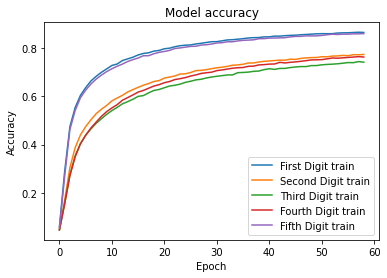

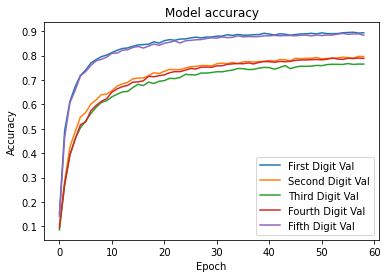

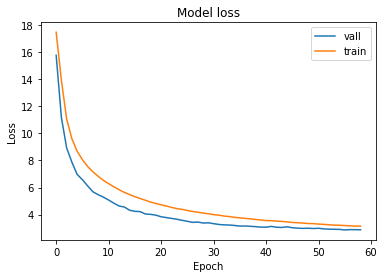

2818/2818 [==============================] - 59s 21ms/step - loss: 1.5641 - digit0_loss: 0.1709 - digit1_loss: 0.3729 - digit2_loss: 0.4617 - digit3_loss: 0.3809 - digit4_loss: 0.1777 - digit0_accuracy: 0.9491 - digit1_accuracy: 0.8974 - digit2_accuracy: 0.8708 - digit3_accuracy: 0.8908 - digit4_accuracy: 0.9481
Train loss:     0.590089
Train accuracy: 62.64
308/308 [==============================] - 7s 21ms/step - loss: 2.8884 - digit0_loss: 0.3376 - digit1_loss: 0.6777 - digit2_loss: 0.8099 - digit3_loss: 0.6999 - digit4_loss: 0.3633 - digit0_accuracy: 0.8903 - digit1_accuracy: 0.7950 - digit2_accuracy: 0.7628 - digit3_accuracy: 0.7904 - digit4_accuracy: 0.8851
Test loss:     1.082688
Test accuracy: 37.77


In [47]:
Trained_model_base_kag,name_base_kag, hist_base_kag = TrainModel(ModelCifar10((25, 67, 1)), x_trainKaggle, s_trainKaggle, x_testKaggle, s_testKaggle )

Total data set size:  100000
Training size:  90159
Testing size:  9841
Validation size: 0.1 of the training set
Number of epochs:  150
Batch size:  256
Model: "LeNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 25, 67, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 21, 63, 6)    156         input_8[0][0]                    
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 10, 31, 6)    0           conv2d_21[0][0]                  
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 6,

2022-01-13 18:08:07.086274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


317/317 [==============================] - ETA: 0s - loss: 17.7929 - digit0_loss: 3.5575 - digit1_loss: 3.5565 - digit2_loss: 3.5556 - digit3_loss: 3.5634 - digit4_loss: 3.5600 - digit0_accuracy: 0.0333 - digit1_accuracy: 0.0332 - digit2_accuracy: 0.0337 - digit3_accuracy: 0.0337 - digit4_accuracy: 0.0334

2022-01-13 18:08:18.211061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


317/317 [==============================] - 12s 37ms/step - loss: 17.7929 - digit0_loss: 3.5575 - digit1_loss: 3.5565 - digit2_loss: 3.5556 - digit3_loss: 3.5634 - digit4_loss: 3.5600 - digit0_accuracy: 0.0333 - digit1_accuracy: 0.0332 - digit2_accuracy: 0.0337 - digit3_accuracy: 0.0337 - digit4_accuracy: 0.0334 - val_loss: 17.6306 - val_digit0_loss: 3.5309 - val_digit1_loss: 3.5275 - val_digit2_loss: 3.5283 - val_digit3_loss: 3.5208 - val_digit4_loss: 3.5231 - val_digit0_accuracy: 0.0399 - val_digit1_accuracy: 0.0329 - val_digit2_accuracy: 0.0332 - val_digit3_accuracy: 0.0343 - val_digit4_accuracy: 0.0364
Epoch 2/150
317/317 [==============================] - 11s 36ms/step - loss: 17.5816 - digit0_loss: 3.5127 - digit1_loss: 3.5135 - digit2_loss: 3.5173 - digit3_loss: 3.5193 - digit4_loss: 3.5188 - digit0_accuracy: 0.0424 - digit1_accuracy: 0.0399 - digit2_accuracy: 0.0387 - digit3_accuracy: 0.0365 - digit4_accuracy: 0.0379 - val_loss: 17.5298 - val_digit0_loss: 3.5018 - val_digit1_los

317/317 [==============================] - 11s 36ms/step - loss: 12.1819 - digit0_loss: 1.9488 - digit1_loss: 2.6120 - digit2_loss: 2.7529 - digit3_loss: 2.7185 - digit4_loss: 2.1498 - digit0_accuracy: 0.4138 - digit1_accuracy: 0.2597 - digit2_accuracy: 0.2271 - digit3_accuracy: 0.2298 - digit4_accuracy: 0.3699 - val_loss: 12.6767 - val_digit0_loss: 2.0594 - val_digit1_loss: 2.7370 - val_digit2_loss: 2.8135 - val_digit3_loss: 2.7928 - val_digit4_loss: 2.2741 - val_digit0_accuracy: 0.3906 - val_digit1_accuracy: 0.2306 - val_digit2_accuracy: 0.2044 - val_digit3_accuracy: 0.2064 - val_digit4_accuracy: 0.3321
Epoch 28/150
317/317 [==============================] - 11s 36ms/step - loss: 12.0839 - digit0_loss: 1.9265 - digit1_loss: 2.5948 - digit2_loss: 2.7341 - digit3_loss: 2.7016 - digit4_loss: 2.1269 - digit0_accuracy: 0.4189 - digit1_accuracy: 0.2645 - digit2_accuracy: 0.2317 - digit3_accuracy: 0.2329 - digit4_accuracy: 0.3750 - val_loss: 12.5654 - val_digit0_loss: 2.0260 - val_digit1_lo

317/317 [==============================] - 11s 36ms/step - loss: 10.7980 - digit0_loss: 1.6587 - digit1_loss: 2.3463 - digit2_loss: 2.5086 - digit3_loss: 2.4372 - digit4_loss: 1.8473 - digit0_accuracy: 0.4936 - digit1_accuracy: 0.3296 - digit2_accuracy: 0.2918 - digit3_accuracy: 0.3013 - digit4_accuracy: 0.4466 - val_loss: 11.5467 - val_digit0_loss: 1.8165 - val_digit1_loss: 2.5261 - val_digit2_loss: 2.6128 - val_digit3_loss: 2.5758 - val_digit4_loss: 2.0154 - val_digit0_accuracy: 0.4575 - val_digit1_accuracy: 0.2859 - val_digit2_accuracy: 0.2648 - val_digit3_accuracy: 0.2680 - val_digit4_accuracy: 0.3990
Epoch 54/150
317/317 [==============================] - 11s 36ms/step - loss: 10.7821 - digit0_loss: 1.6530 - digit1_loss: 2.3419 - digit2_loss: 2.5058 - digit3_loss: 2.4311 - digit4_loss: 1.8503 - digit0_accuracy: 0.4957 - digit1_accuracy: 0.3314 - digit2_accuracy: 0.2924 - digit3_accuracy: 0.3013 - digit4_accuracy: 0.4470 - val_loss: 11.4939 - val_digit0_loss: 1.8086 - val_digit1_lo

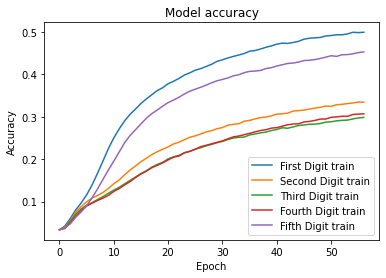

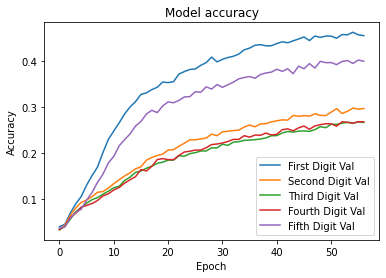

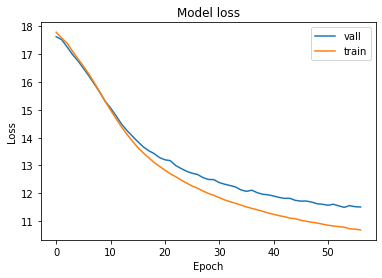

2818/2818 [==============================] - 61s 21ms/step - loss: 10.6539 - digit0_loss: 1.6391 - digit1_loss: 2.3192 - digit2_loss: 2.4714 - digit3_loss: 2.4093 - digit4_loss: 1.8148 - digit0_accuracy: 0.4986 - digit1_accuracy: 0.3380 - digit2_accuracy: 0.3022 - digit3_accuracy: 0.3091 - digit4_accuracy: 0.4560
Train loss:     3.898599
Train accuracy: 0.72
308/308 [==============================] - 7s 22ms/step - loss: 11.6094 - digit0_loss: 1.8769 - digit1_loss: 2.4740 - digit2_loss: 2.6225 - digit3_loss: 2.5982 - digit4_loss: 2.0378 - digit0_accuracy: 0.4376 - digit1_accuracy: 0.2990 - digit2_accuracy: 0.2666 - digit3_accuracy: 0.2664 - digit4_accuracy: 0.4008
Test loss:     4.236190
Test accuracy: 0.37


In [48]:
Trained_model_lenet_kag,name_lenet_kag, hist_lenet_kag = TrainModel(ModelLeNet((25, 67, 1)), x_trainKaggle, s_trainKaggle, x_testKaggle, s_testKaggle )

Total data set size:  100000
Training size:  90159
Testing size:  9841
Validation size: 0.1 of the training set
Number of epochs:  150
Batch size:  256
Model: "VGG16_simplfied"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 25, 67, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 25, 67, 32)   320         input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 25, 67, 32)   9248        conv2d_23[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_21 (MaxPooling2D)

2022-01-13 18:41:58.045684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


317/317 [==============================] - ETA: 0s - loss: 17.7388 - digit0_loss: 3.5482 - digit1_loss: 3.5485 - digit2_loss: 3.5493 - digit3_loss: 3.5464 - digit4_loss: 3.5463 - digit0_accuracy: 0.0335 - digit1_accuracy: 0.0317 - digit2_accuracy: 0.0333 - digit3_accuracy: 0.0326 - digit4_accuracy: 0.0329

2022-01-13 18:42:32.686006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


317/317 [==============================] - 37s 112ms/step - loss: 17.7388 - digit0_loss: 3.5482 - digit1_loss: 3.5485 - digit2_loss: 3.5493 - digit3_loss: 3.5464 - digit4_loss: 3.5463 - digit0_accuracy: 0.0335 - digit1_accuracy: 0.0317 - digit2_accuracy: 0.0333 - digit3_accuracy: 0.0326 - digit4_accuracy: 0.0329 - val_loss: 17.6121 - val_digit0_loss: 3.5272 - val_digit1_loss: 3.5254 - val_digit2_loss: 3.5226 - val_digit3_loss: 3.5174 - val_digit4_loss: 3.5194 - val_digit0_accuracy: 0.0347 - val_digit1_accuracy: 0.0354 - val_digit2_accuracy: 0.0333 - val_digit3_accuracy: 0.0284 - val_digit4_accuracy: 0.0317
Epoch 2/150
317/317 [==============================] - 35s 110ms/step - loss: 17.4200 - digit0_loss: 3.4113 - digit1_loss: 3.5142 - digit2_loss: 3.5125 - digit3_loss: 3.5152 - digit4_loss: 3.4669 - digit0_accuracy: 0.0497 - digit1_accuracy: 0.0375 - digit2_accuracy: 0.0390 - digit3_accuracy: 0.0377 - digit4_accuracy: 0.0425 - val_loss: 16.3602 - val_digit0_loss: 2.9599 - val_digit1_l

317/317 [==============================] - 35s 111ms/step - loss: 2.3211 - digit0_loss: 0.2701 - digit1_loss: 0.5375 - digit2_loss: 0.6998 - digit3_loss: 0.5486 - digit4_loss: 0.2651 - digit0_accuracy: 0.9169 - digit1_accuracy: 0.8292 - digit2_accuracy: 0.7764 - digit3_accuracy: 0.8259 - digit4_accuracy: 0.9215 - val_loss: 1.9017 - val_digit0_loss: 0.2395 - val_digit1_loss: 0.4379 - val_digit2_loss: 0.5454 - val_digit3_loss: 0.4711 - val_digit4_loss: 0.2079 - val_digit0_accuracy: 0.9308 - val_digit1_accuracy: 0.8746 - val_digit2_accuracy: 0.8391 - val_digit3_accuracy: 0.8661 - val_digit4_accuracy: 0.9452
Epoch 28/150
317/317 [==============================] - 35s 110ms/step - loss: 2.2336 - digit0_loss: 0.2613 - digit1_loss: 0.5142 - digit2_loss: 0.6696 - digit3_loss: 0.5293 - digit4_loss: 0.2591 - digit0_accuracy: 0.9204 - digit1_accuracy: 0.8356 - digit2_accuracy: 0.7857 - digit3_accuracy: 0.8330 - digit4_accuracy: 0.9247 - val_loss: 1.9253 - val_digit0_loss: 0.2561 - val_digit1_loss

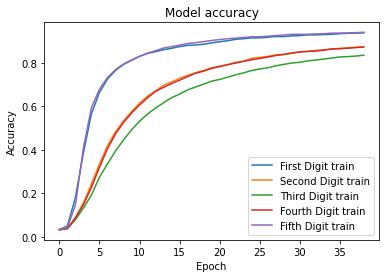

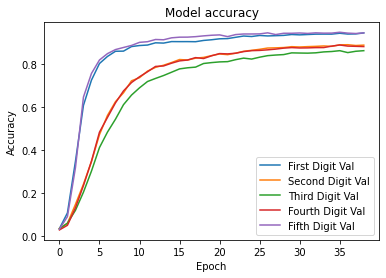

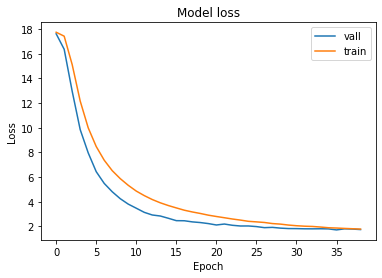

2818/2818 [==============================] - 69s 24ms/step - loss: 0.8863 - digit0_loss: 0.1020 - digit1_loss: 0.2038 - digit2_loss: 0.2675 - digit3_loss: 0.2117 - digit4_loss: 0.1013 - digit0_accuracy: 0.9696 - digit1_accuracy: 0.9357 - digit2_accuracy: 0.9176 - digit3_accuracy: 0.9328 - digit4_accuracy: 0.9696
Train loss:     0.334259
Train accuracy: 75.29
308/308 [==============================] - 8s 25ms/step - loss: 1.7803 - digit0_loss: 0.2353 - digit1_loss: 0.3861 - digit2_loss: 0.4863 - digit3_loss: 0.4067 - digit4_loss: 0.2659 - digit0_accuracy: 0.9431 - digit1_accuracy: 0.8885 - digit2_accuracy: 0.8620 - digit3_accuracy: 0.8846 - digit4_accuracy: 0.9395
Test loss:     0.658943
Test accuracy: 60.03


In [50]:
Trained_model_vg16_kag,name_vg16_kag, hist_vg16_kag = TrainModel(ModelVGG16((25, 67, 1)), x_trainKaggle, s_trainKaggle, x_testKaggle, s_testKaggle )

Total data set size:  100000
Training size:  90159
Testing size:  9841
Validation size: 0.1 of the training set
Number of epochs:  150
Batch size:  256
Model: "AlexNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 25, 67, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 7, 17, 96)    11712       input_13[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_34 (MaxPooling2D) (None, 4, 9, 96)     0           conv2d_46[0][0]                  
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 

2022-01-13 19:18:00.865965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


317/317 [==============================] - ETA: 0s - loss: 17.8357 - digit0_loss: 3.5686 - digit1_loss: 3.5652 - digit2_loss: 3.5660 - digit3_loss: 3.5595 - digit4_loss: 3.5764 - digit0_accuracy: 0.0328 - digit1_accuracy: 0.0335 - digit2_accuracy: 0.0333 - digit3_accuracy: 0.0328 - digit4_accuracy: 0.0326

2022-01-13 19:18:28.976836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


317/317 [==============================] - 30s 91ms/step - loss: 17.8357 - digit0_loss: 3.5686 - digit1_loss: 3.5652 - digit2_loss: 3.5660 - digit3_loss: 3.5595 - digit4_loss: 3.5764 - digit0_accuracy: 0.0328 - digit1_accuracy: 0.0335 - digit2_accuracy: 0.0333 - digit3_accuracy: 0.0328 - digit4_accuracy: 0.0326 - val_loss: 17.6220 - val_digit0_loss: 3.5299 - val_digit1_loss: 3.5310 - val_digit2_loss: 3.5224 - val_digit3_loss: 3.5180 - val_digit4_loss: 3.5207 - val_digit0_accuracy: 0.0350 - val_digit1_accuracy: 0.0357 - val_digit2_accuracy: 0.0356 - val_digit3_accuracy: 0.0324 - val_digit4_accuracy: 0.0312
Epoch 2/150
317/317 [==============================] - 29s 90ms/step - loss: 17.6157 - digit0_loss: 3.5233 - digit1_loss: 3.5221 - digit2_loss: 3.5243 - digit3_loss: 3.5227 - digit4_loss: 3.5233 - digit0_accuracy: 0.0336 - digit1_accuracy: 0.0329 - digit2_accuracy: 0.0337 - digit3_accuracy: 0.0335 - digit4_accuracy: 0.0322 - val_loss: 17.6067 - val_digit0_loss: 3.5266 - val_digit1_los

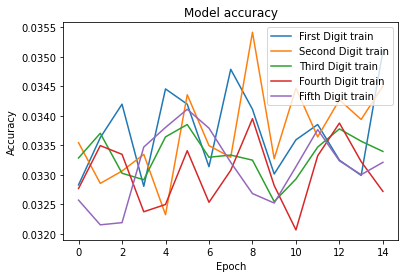

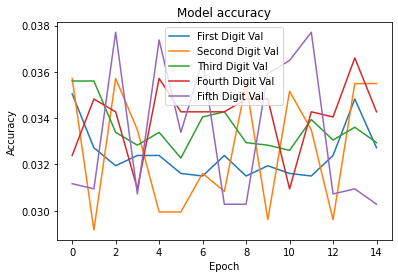

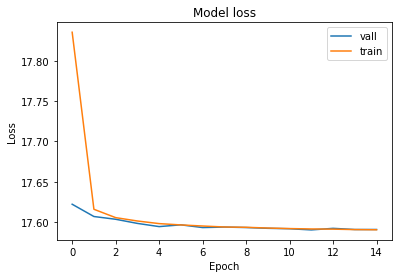

2818/2818 [==============================] - 67s 24ms/step - loss: 17.5886 - digit0_loss: 3.5186 - digit1_loss: 3.5176 - digit2_loss: 3.5184 - digit3_loss: 3.5172 - digit4_loss: 3.5169 - digit0_accuracy: 0.0340 - digit1_accuracy: 0.0353 - digit2_accuracy: 0.0337 - digit3_accuracy: 0.0342 - digit4_accuracy: 0.0339
Train loss:     6.332075
Train accuracy: 0.00
308/308 [==============================] - 7s 24ms/step - loss: 17.5830 - digit0_loss: 3.5205 - digit1_loss: 3.5126 - digit2_loss: 3.5147 - digit3_loss: 3.5152 - digit4_loss: 3.5199 - digit0_accuracy: 0.0357 - digit1_accuracy: 0.0333 - digit2_accuracy: 0.0314 - digit3_accuracy: 0.0333 - digit4_accuracy: 0.0337
Test loss:     6.329224
Test accuracy: 0.00


In [56]:
Trained_model_alex_kag,name_alex_kag, hist_alex_kag = TrainModel(ModelAlexnet((25, 67, 1)), x_trainKaggle, s_trainKaggle, x_testKaggle, s_testKaggle)

Total data set size:  100000
Training size:  89961
Testing size:  10039
Validation size: 0.1 of the training set
Number of epochs:  150
Batch size:  256
Model: "AlexNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 25, 67, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_51 (Conv2D)              (None, 7, 17, 96)    11712       input_14[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_37 (MaxPooling2D) (None, 4, 9, 96)     0           conv2d_51[0][0]                  
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None,

2022-01-13 19:34:10.066587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


317/317 [==============================] - ETA: 0s - loss: 17.8391 - digit0_loss: 3.5648 - digit1_loss: 3.5643 - digit2_loss: 3.5664 - digit3_loss: 3.5759 - digit4_loss: 3.5677 - digit0_accuracy: 0.0327 - digit1_accuracy: 0.0338 - digit2_accuracy: 0.0334 - digit3_accuracy: 0.0334 - digit4_accuracy: 0.0329

2022-01-13 19:34:37.950398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


317/317 [==============================] - 30s 90ms/step - loss: 17.8391 - digit0_loss: 3.5648 - digit1_loss: 3.5643 - digit2_loss: 3.5664 - digit3_loss: 3.5759 - digit4_loss: 3.5677 - digit0_accuracy: 0.0327 - digit1_accuracy: 0.0338 - digit2_accuracy: 0.0334 - digit3_accuracy: 0.0334 - digit4_accuracy: 0.0329 - val_loss: 17.6146 - val_digit0_loss: 3.5284 - val_digit1_loss: 3.5275 - val_digit2_loss: 3.5189 - val_digit3_loss: 3.5185 - val_digit4_loss: 3.5213 - val_digit0_accuracy: 0.0316 - val_digit1_accuracy: 0.0315 - val_digit2_accuracy: 0.0330 - val_digit3_accuracy: 0.0287 - val_digit4_accuracy: 0.0306
Epoch 2/150
317/317 [==============================] - 28s 88ms/step - loss: 17.6128 - digit0_loss: 3.5239 - digit1_loss: 3.5208 - digit2_loss: 3.5233 - digit3_loss: 3.5220 - digit4_loss: 3.5228 - digit0_accuracy: 0.0340 - digit1_accuracy: 0.0339 - digit2_accuracy: 0.0338 - digit3_accuracy: 0.0342 - digit4_accuracy: 0.0332 - val_loss: 17.6047 - val_digit0_loss: 3.5266 - val_digit1_los

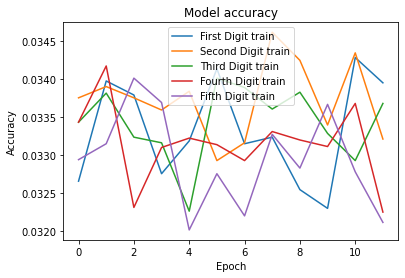

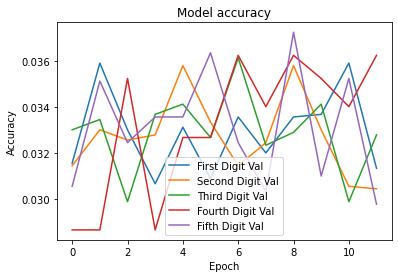

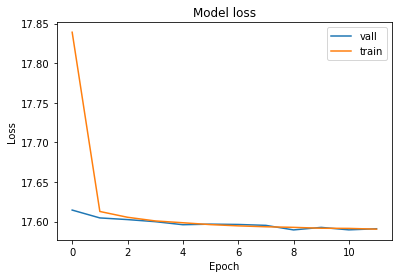

2812/2812 [==============================] - 68s 24ms/step - loss: 17.5881 - digit0_loss: 3.5189 - digit1_loss: 3.5166 - digit2_loss: 3.5181 - digit3_loss: 3.5168 - digit4_loss: 3.5176 - digit0_accuracy: 0.0336 - digit1_accuracy: 0.0333 - digit2_accuracy: 0.0329 - digit3_accuracy: 0.0341 - digit4_accuracy: 0.0339
Train loss:     6.331708
Train accuracy: 0.00
314/314 [==============================] - 8s 25ms/step - loss: 17.5969 - digit0_loss: 3.5177 - digit1_loss: 3.5218 - digit2_loss: 3.5192 - digit3_loss: 3.5218 - digit4_loss: 3.5165 - digit0_accuracy: 0.0328 - digit1_accuracy: 0.0323 - digit2_accuracy: 0.0346 - digit3_accuracy: 0.0340 - digit4_accuracy: 0.0339
Test loss:     6.335472
Test accuracy: 0.00


In [74]:
Trained_model = TrainModel(ModelAlexnet((25, 67, 1)), x_trainKaggle, s_trainKaggle, x_testKaggle, s_testKaggle)

Total data set size:  100000
Training size:  89961
Testing size:  10039
Validation size: 0.1 of the training set
Number of epochs:  150
Batch size:  256
Model: "VGG19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 25, 67, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_80 (Conv2D)              (None, 25, 67, 64)   640         input_17[0][0]                   
__________________________________________________________________________________________________
conv2d_81 (Conv2D)              (None, 25, 67, 64)   36928       conv2d_80[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_49 (MaxPooling2D) (None, 1

2022-01-13 19:42:26.807093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


317/317 [==============================] - ETA: 0s - loss: 19.3070 - digit0_loss: 3.8655 - digit1_loss: 3.8488 - digit2_loss: 3.8502 - digit3_loss: 3.8765 - digit4_loss: 3.8660 - digit0_accuracy: 0.0337 - digit1_accuracy: 0.0340 - digit2_accuracy: 0.0344 - digit3_accuracy: 0.0338 - digit4_accuracy: 0.0331

2022-01-13 19:44:38.078034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


317/317 [==============================] - 136s 427ms/step - loss: 19.3070 - digit0_loss: 3.8655 - digit1_loss: 3.8488 - digit2_loss: 3.8502 - digit3_loss: 3.8765 - digit4_loss: 3.8660 - digit0_accuracy: 0.0337 - digit1_accuracy: 0.0340 - digit2_accuracy: 0.0344 - digit3_accuracy: 0.0338 - digit4_accuracy: 0.0331 - val_loss: 17.5976 - val_digit0_loss: 3.5250 - val_digit1_loss: 3.5227 - val_digit2_loss: 3.5168 - val_digit3_loss: 3.5147 - val_digit4_loss: 3.5184 - val_digit0_accuracy: 0.0316 - val_digit1_accuracy: 0.0309 - val_digit2_accuracy: 0.0330 - val_digit3_accuracy: 0.0332 - val_digit4_accuracy: 0.0298
Epoch 2/150
317/317 [==============================] - 135s 426ms/step - loss: 17.6036 - digit0_loss: 3.5216 - digit1_loss: 3.5188 - digit2_loss: 3.5216 - digit3_loss: 3.5204 - digit4_loss: 3.5212 - digit0_accuracy: 0.0332 - digit1_accuracy: 0.0338 - digit2_accuracy: 0.0333 - digit3_accuracy: 0.0327 - digit4_accuracy: 0.0317 - val_loss: 17.5976 - val_digit0_loss: 3.5256 - val_digit1

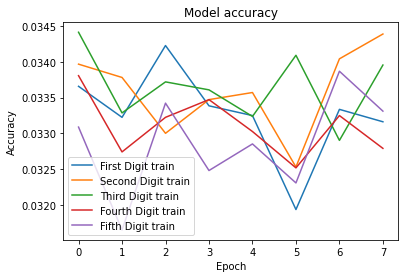

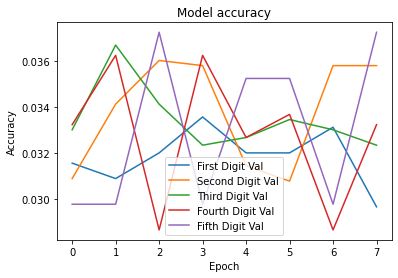

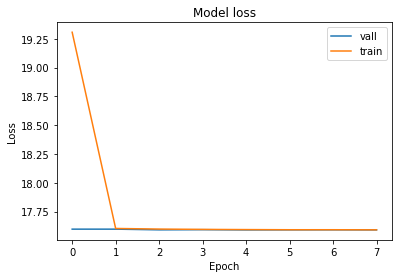

2812/2812 [==============================] - 85s 30ms/step - loss: 17.5885 - digit0_loss: 3.5190 - digit1_loss: 3.5164 - digit2_loss: 3.5186 - digit3_loss: 3.5166 - digit4_loss: 3.5179 - digit0_accuracy: 0.0325 - digit1_accuracy: 0.0352 - digit2_accuracy: 0.0334 - digit3_accuracy: 0.0340 - digit4_accuracy: 0.0341
Train loss:     6.331828
Train accuracy: 0.00
314/314 [==============================] - 10s 30ms/step - loss: 17.5975 - digit0_loss: 3.5176 - digit1_loss: 3.5209 - digit2_loss: 3.5204 - digit3_loss: 3.5216 - digit4_loss: 3.5171 - digit0_accuracy: 0.0307 - digit1_accuracy: 0.0341 - digit2_accuracy: 0.0318 - digit3_accuracy: 0.0316 - digit4_accuracy: 0.0323
Test loss:     6.335596
Test accuracy: 0.00


In [77]:
Trained_model_vg19_kag,name_vg19_kag, hist_vg19_kag = TrainModel(ModelVGG19((25, 67, 1)), x_trainKaggle, s_trainKaggle, x_testKaggle, s_testKaggle)


Total data set size:  100000
Training size:  89961
Testing size:  10039
Validation size: 0.1 of the training set
Number of epochs:  150
Batch size:  256
Model: "VGG16Complex"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 25, 67, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_104 (Conv2D)             (None, 25, 67, 32)   320         input_19[0][0]                   
__________________________________________________________________________________________________
conv2d_105 (Conv2D)             (None, 25, 67, 32)   9248        conv2d_104[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_58 (MaxPooling2D) (

2022-01-13 20:13:18.478928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


317/317 [==============================] - ETA: 0s - loss: 17.7716 - digit0_loss: 3.5549 - digit1_loss: 3.5537 - digit2_loss: 3.5538 - digit3_loss: 3.5532 - digit4_loss: 3.5560 - digit0_accuracy: 0.0333 - digit1_accuracy: 0.0338 - digit2_accuracy: 0.0337 - digit3_accuracy: 0.0326 - digit4_accuracy: 0.0333

2022-01-13 20:13:58.512842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


317/317 [==============================] - 43s 129ms/step - loss: 17.7716 - digit0_loss: 3.5549 - digit1_loss: 3.5537 - digit2_loss: 3.5538 - digit3_loss: 3.5532 - digit4_loss: 3.5560 - digit0_accuracy: 0.0333 - digit1_accuracy: 0.0338 - digit2_accuracy: 0.0337 - digit3_accuracy: 0.0326 - digit4_accuracy: 0.0333 - val_loss: 17.6199 - val_digit0_loss: 3.5288 - val_digit1_loss: 3.5264 - val_digit2_loss: 3.5224 - val_digit3_loss: 3.5200 - val_digit4_loss: 3.5223 - val_digit0_accuracy: 0.0336 - val_digit1_accuracy: 0.0358 - val_digit2_accuracy: 0.0327 - val_digit3_accuracy: 0.0353 - val_digit4_accuracy: 0.0307
Epoch 2/150
317/317 [==============================] - 40s 126ms/step - loss: 17.6173 - digit0_loss: 3.5241 - digit1_loss: 3.5216 - digit2_loss: 3.5247 - digit3_loss: 3.5233 - digit4_loss: 3.5237 - digit0_accuracy: 0.0327 - digit1_accuracy: 0.0330 - digit2_accuracy: 0.0325 - digit3_accuracy: 0.0338 - digit4_accuracy: 0.0334 - val_loss: 17.6070 - val_digit0_loss: 3.5287 - val_digit1_l

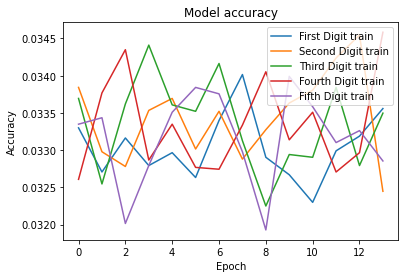

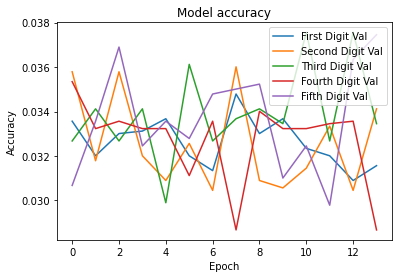

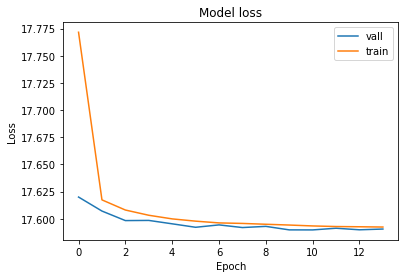

2812/2812 [==============================] - 72s 26ms/step - loss: 17.5872 - digit0_loss: 3.5188 - digit1_loss: 3.5165 - digit2_loss: 3.5179 - digit3_loss: 3.5166 - digit4_loss: 3.5174 - digit0_accuracy: 0.0341 - digit1_accuracy: 0.0337 - digit2_accuracy: 0.0333 - digit3_accuracy: 0.0336 - digit4_accuracy: 0.0335
Train loss:     6.331414
Train accuracy: 0.00
314/314 [==============================] - 8s 26ms/step - loss: 17.5976 - digit0_loss: 3.5175 - digit1_loss: 3.5218 - digit2_loss: 3.5201 - digit3_loss: 3.5215 - digit4_loss: 3.5167 - digit0_accuracy: 0.0363 - digit1_accuracy: 0.0326 - digit2_accuracy: 0.0315 - digit3_accuracy: 0.0308 - digit4_accuracy: 0.0332
Test loss:     6.335697
Test accuracy: 0.00


In [85]:
Trained_model_vg16c_kag,name_vg16c_kag, hist_vg16c_kag = TrainModel(ModelVGG16complex((25, 67, 1)), x_trainKaggle, s_trainKaggle, x_testKaggle, s_testKaggle )

# Tests on the generated captcha dataset

Total data set size:  100000
Training size:  89954
Testing size:  10046
Validation size: 0.1 of the training set
Number of epochs:  150
Batch size:  256
Model: "BaseModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 25, 67, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_112 (Conv2D)             (None, 25, 67, 32)   832         input_20[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_62 (MaxPooling2D) (None, 12, 33, 32)   0           conv2d_112[0][0]                 
__________________________________________________________________________________________________
conv2d_113 (Conv2D)             (Non

2022-01-13 20:36:51.200902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


317/317 [==============================] - ETA: 0s - loss: 17.9341 - digit0_loss: 3.5774 - digit1_loss: 3.5901 - digit2_loss: 3.5890 - digit3_loss: 3.5902 - digit4_loss: 3.5874 - digit0_accuracy: 0.0350 - digit1_accuracy: 0.0320 - digit2_accuracy: 0.0332 - digit3_accuracy: 0.0320 - digit4_accuracy: 0.0327

2022-01-13 20:37:07.517880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


317/317 [==============================] - 18s 53ms/step - loss: 17.9341 - digit0_loss: 3.5774 - digit1_loss: 3.5901 - digit2_loss: 3.5890 - digit3_loss: 3.5902 - digit4_loss: 3.5874 - digit0_accuracy: 0.0350 - digit1_accuracy: 0.0320 - digit2_accuracy: 0.0332 - digit3_accuracy: 0.0320 - digit4_accuracy: 0.0327 - val_loss: 17.5902 - val_digit0_loss: 3.4429 - val_digit1_loss: 3.5364 - val_digit2_loss: 3.5545 - val_digit3_loss: 3.5367 - val_digit4_loss: 3.5198 - val_digit0_accuracy: 0.0517 - val_digit1_accuracy: 0.0409 - val_digit2_accuracy: 0.0432 - val_digit3_accuracy: 0.0365 - val_digit4_accuracy: 0.0466
Epoch 2/150
317/317 [==============================] - 16s 52ms/step - loss: 14.2411 - digit0_loss: 2.5430 - digit1_loss: 3.0521 - digit2_loss: 3.0882 - digit3_loss: 3.0066 - digit4_loss: 2.5513 - digit0_accuracy: 0.2701 - digit1_accuracy: 0.1604 - digit2_accuracy: 0.1538 - digit3_accuracy: 0.1678 - digit4_accuracy: 0.2651 - val_loss: 9.9567 - val_digit0_loss: 1.4585 - val_digit1_loss

317/317 [==============================] - 16s 51ms/step - loss: 2.7768 - digit0_loss: 0.3663 - digit1_loss: 0.6799 - digit2_loss: 0.7248 - digit3_loss: 0.6474 - digit4_loss: 0.3585 - digit0_accuracy: 0.8762 - digit1_accuracy: 0.7838 - digit2_accuracy: 0.7742 - digit3_accuracy: 0.7918 - digit4_accuracy: 0.8776 - val_loss: 1.8419 - val_digit0_loss: 0.2119 - val_digit1_loss: 0.4549 - val_digit2_loss: 0.4952 - val_digit3_loss: 0.4432 - val_digit4_loss: 0.2367 - val_digit0_accuracy: 0.9300 - val_digit1_accuracy: 0.8643 - val_digit2_accuracy: 0.8553 - val_digit3_accuracy: 0.8638 - val_digit4_accuracy: 0.9220
Epoch 28/150
317/317 [==============================] - 16s 51ms/step - loss: 2.6986 - digit0_loss: 0.3557 - digit1_loss: 0.6586 - digit2_loss: 0.7111 - digit3_loss: 0.6293 - digit4_loss: 0.3438 - digit0_accuracy: 0.8799 - digit1_accuracy: 0.7893 - digit2_accuracy: 0.7770 - digit3_accuracy: 0.7988 - digit4_accuracy: 0.8826 - val_loss: 1.7612 - val_digit0_loss: 0.2051 - val_digit1_loss: 

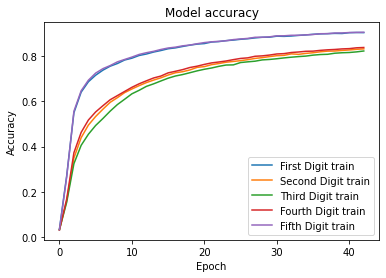

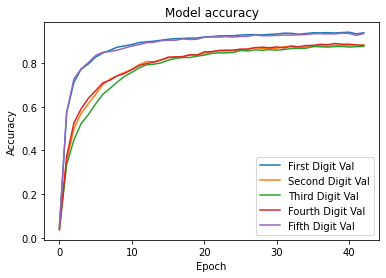

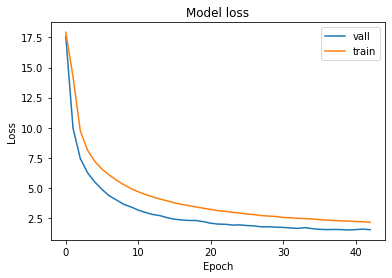

2812/2812 [==============================] - 68s 24ms/step - loss: 0.9085 - digit0_loss: 0.1038 - digit1_loss: 0.2239 - digit2_loss: 0.2499 - digit3_loss: 0.2243 - digit4_loss: 0.1066 - digit0_accuracy: 0.9675 - digit1_accuracy: 0.9367 - digit2_accuracy: 0.9297 - digit3_accuracy: 0.9368 - digit4_accuracy: 0.9671
Train loss:     0.342088
Train accuracy: 76.34
314/314 [==============================] - 8s 25ms/step - loss: 1.5623 - digit0_loss: 0.1813 - digit1_loss: 0.3744 - digit2_loss: 0.4279 - digit3_loss: 0.3947 - digit4_loss: 0.1840 - digit0_accuracy: 0.9388 - digit1_accuracy: 0.8790 - digit2_accuracy: 0.8710 - digit3_accuracy: 0.8779 - digit4_accuracy: 0.9330
Test loss:     0.588124
Test accuracy: 58.87


In [90]:
Trained_model_base_gen,name_base_gen, hist_base_gen = TrainModel(ModelCifar10((25, 67, 1)), x_trainGen, s_trainGen, x_testGen, s_testGen, 'Gen')

Total data set size:  100000
Training size:  89954
Testing size:  10046
Validation size: 0.1 of the training set
Number of epochs:  150
Batch size:  256
Model: "LeNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 25, 67, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_115 (Conv2D)             (None, 21, 63, 6)    156         input_21[0][0]                   
__________________________________________________________________________________________________
average_pooling2d_2 (AveragePoo (None, 10, 31, 6)    0           conv2d_115[0][0]                 
__________________________________________________________________________________________________
conv2d_116 (Conv2D)             (None, 6

2022-01-13 20:49:46.881933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


317/317 [==============================] - ETA: 0s - loss: 17.9181 - digit0_loss: 3.5846 - digit1_loss: 3.5859 - digit2_loss: 3.5823 - digit3_loss: 3.5824 - digit4_loss: 3.5830 - digit0_accuracy: 0.0312 - digit1_accuracy: 0.0313 - digit2_accuracy: 0.0312 - digit3_accuracy: 0.0320 - digit4_accuracy: 0.0321

2022-01-13 20:49:59.345527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


317/317 [==============================] - 14s 42ms/step - loss: 17.9181 - digit0_loss: 3.5846 - digit1_loss: 3.5859 - digit2_loss: 3.5823 - digit3_loss: 3.5824 - digit4_loss: 3.5830 - digit0_accuracy: 0.0312 - digit1_accuracy: 0.0313 - digit2_accuracy: 0.0312 - digit3_accuracy: 0.0320 - digit4_accuracy: 0.0321 - val_loss: 17.7585 - val_digit0_loss: 3.5526 - val_digit1_loss: 3.5534 - val_digit2_loss: 3.5562 - val_digit3_loss: 3.5525 - val_digit4_loss: 3.5439 - val_digit0_accuracy: 0.0336 - val_digit1_accuracy: 0.0320 - val_digit2_accuracy: 0.0326 - val_digit3_accuracy: 0.0346 - val_digit4_accuracy: 0.0359
Epoch 2/150
317/317 [==============================] - 12s 39ms/step - loss: 17.3388 - digit0_loss: 3.4638 - digit1_loss: 3.4770 - digit2_loss: 3.4963 - digit3_loss: 3.4814 - digit4_loss: 3.4203 - digit0_accuracy: 0.0640 - digit1_accuracy: 0.0608 - digit2_accuracy: 0.0558 - digit3_accuracy: 0.0565 - digit4_accuracy: 0.0712 - val_loss: 16.4066 - val_digit0_loss: 3.2591 - val_digit1_los

317/317 [==============================] - 13s 41ms/step - loss: 10.0387 - digit0_loss: 1.6447 - digit1_loss: 2.2454 - digit2_loss: 2.3014 - digit3_loss: 2.1657 - digit4_loss: 1.6815 - digit0_accuracy: 0.5056 - digit1_accuracy: 0.3447 - digit2_accuracy: 0.3338 - digit3_accuracy: 0.3735 - digit4_accuracy: 0.5011 - val_loss: 10.3552 - val_digit0_loss: 1.7022 - val_digit1_loss: 2.3199 - val_digit2_loss: 2.3570 - val_digit3_loss: 2.2406 - val_digit4_loss: 1.7356 - val_digit0_accuracy: 0.4828 - val_digit1_accuracy: 0.3254 - val_digit2_accuracy: 0.3236 - val_digit3_accuracy: 0.3470 - val_digit4_accuracy: 0.4827
Epoch 28/150
317/317 [==============================] - 13s 41ms/step - loss: 9.9023 - digit0_loss: 1.6185 - digit1_loss: 2.2203 - digit2_loss: 2.2734 - digit3_loss: 2.1387 - digit4_loss: 1.6513 - digit0_accuracy: 0.5120 - digit1_accuracy: 0.3550 - digit2_accuracy: 0.3438 - digit3_accuracy: 0.3812 - digit4_accuracy: 0.5103 - val_loss: 10.3441 - val_digit0_loss: 1.7231 - val_digit1_los

317/317 [==============================] - 13s 41ms/step - loss: 8.0219 - digit0_loss: 1.2366 - digit1_loss: 1.8599 - digit2_loss: 1.9097 - digit3_loss: 1.7581 - digit4_loss: 1.2575 - digit0_accuracy: 0.6218 - digit1_accuracy: 0.4529 - digit2_accuracy: 0.4437 - digit3_accuracy: 0.4843 - digit4_accuracy: 0.6188 - val_loss: 8.7592 - val_digit0_loss: 1.4308 - val_digit1_loss: 2.0239 - val_digit2_loss: 2.0530 - val_digit3_loss: 1.8919 - val_digit4_loss: 1.3595 - val_digit0_accuracy: 0.5641 - val_digit1_accuracy: 0.4152 - val_digit2_accuracy: 0.4058 - val_digit3_accuracy: 0.4471 - val_digit4_accuracy: 0.5871
Epoch 54/150
317/317 [==============================] - 13s 41ms/step - loss: 7.9655 - digit0_loss: 1.2246 - digit1_loss: 1.8494 - digit2_loss: 1.9001 - digit3_loss: 1.7446 - digit4_loss: 1.2468 - digit0_accuracy: 0.6249 - digit1_accuracy: 0.4549 - digit2_accuracy: 0.4470 - digit3_accuracy: 0.4874 - digit4_accuracy: 0.6236 - val_loss: 8.7075 - val_digit0_loss: 1.3824 - val_digit1_loss: 

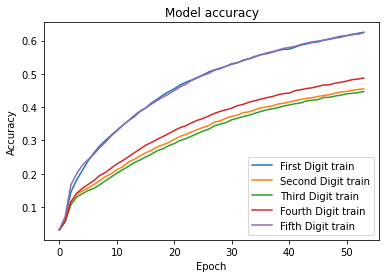

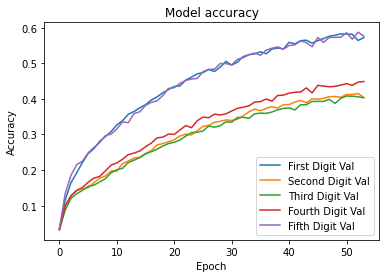

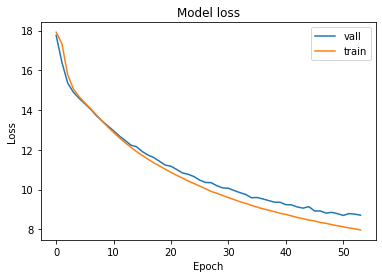

2812/2812 [==============================] - 70s 25ms/step - loss: 8.0366 - digit0_loss: 1.2686 - digit1_loss: 1.8811 - digit2_loss: 1.8945 - digit3_loss: 1.7383 - digit4_loss: 1.2541 - digit0_accuracy: 0.6107 - digit1_accuracy: 0.4460 - digit2_accuracy: 0.4459 - digit3_accuracy: 0.4880 - digit4_accuracy: 0.6200
Train loss:     2.963826
Train accuracy: 3.67
314/314 [==============================] - 8s 25ms/step - loss: 8.7296 - digit0_loss: 1.4056 - digit1_loss: 2.0233 - digit2_loss: 2.0439 - digit3_loss: 1.8748 - digit4_loss: 1.3820 - digit0_accuracy: 0.5711 - digit1_accuracy: 0.4063 - digit2_accuracy: 0.4090 - digit3_accuracy: 0.4517 - digit4_accuracy: 0.5802
Test loss:     3.215430
Test accuracy: 2.49


In [91]:
Trained_model_lenet_gen,name_lenet_gen, hist_lenet_gen = TrainModel(ModelLeNet((25, 67, 1)), x_trainGen, s_trainGen, x_testGen, s_testGen, 'Gen')

Total data set size:  100000
Training size:  89954
Testing size:  10046
Validation size: 0.1 of the training set
Number of epochs:  150
Batch size:  256
Model: "VGG16_simplfied"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 25, 67, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_125 (Conv2D)             (None, 25, 67, 32)   320         input_23[0][0]                   
__________________________________________________________________________________________________
conv2d_126 (Conv2D)             (None, 25, 67, 32)   9248        conv2d_125[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_69 (MaxPooling2D

2022-01-13 21:17:40.540883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


317/317 [==============================] - ETA: 0s - loss: 17.8685 - digit0_loss: 3.5733 - digit1_loss: 3.5730 - digit2_loss: 3.5727 - digit3_loss: 3.5766 - digit4_loss: 3.5730 - digit0_accuracy: 0.0327 - digit1_accuracy: 0.0324 - digit2_accuracy: 0.0322 - digit3_accuracy: 0.0325 - digit4_accuracy: 0.0325

2022-01-13 21:18:15.029242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


317/317 [==============================] - 36s 112ms/step - loss: 17.8685 - digit0_loss: 3.5733 - digit1_loss: 3.5730 - digit2_loss: 3.5727 - digit3_loss: 3.5766 - digit4_loss: 3.5730 - digit0_accuracy: 0.0327 - digit1_accuracy: 0.0324 - digit2_accuracy: 0.0322 - digit3_accuracy: 0.0325 - digit4_accuracy: 0.0325 - val_loss: 17.7493 - val_digit0_loss: 3.5503 - val_digit1_loss: 3.5507 - val_digit2_loss: 3.5555 - val_digit3_loss: 3.5515 - val_digit4_loss: 3.5413 - val_digit0_accuracy: 0.0315 - val_digit1_accuracy: 0.0336 - val_digit2_accuracy: 0.0309 - val_digit3_accuracy: 0.0320 - val_digit4_accuracy: 0.0329
Epoch 2/150
317/317 [==============================] - 35s 110ms/step - loss: 17.7557 - digit0_loss: 3.5502 - digit1_loss: 3.5518 - digit2_loss: 3.5514 - digit3_loss: 3.5522 - digit4_loss: 3.5501 - digit0_accuracy: 0.0326 - digit1_accuracy: 0.0328 - digit2_accuracy: 0.0314 - digit3_accuracy: 0.0316 - digit4_accuracy: 0.0330 - val_loss: 17.7367 - val_digit0_loss: 3.5483 - val_digit1_l

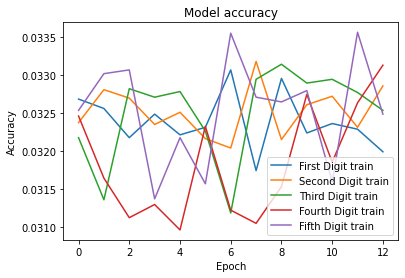

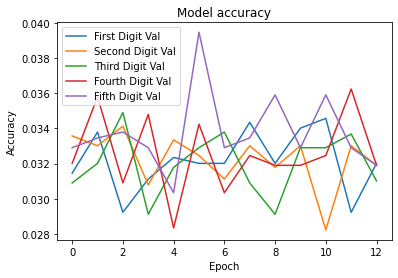

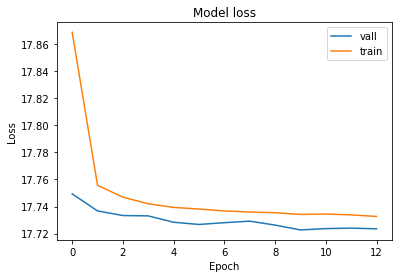

2812/2812 [==============================] - 78s 28ms/step - loss: 17.7277 - digit0_loss: 3.5447 - digit1_loss: 3.5465 - digit2_loss: 3.5461 - digit3_loss: 3.5466 - digit4_loss: 3.5439 - digit0_accuracy: 0.0332 - digit1_accuracy: 0.0322 - digit2_accuracy: 0.0328 - digit3_accuracy: 0.0327 - digit4_accuracy: 0.0325
Train loss:     6.382308
Train accuracy: 0.00
314/314 [==============================] - 9s 28ms/step - loss: 17.7347 - digit0_loss: 3.5419 - digit1_loss: 3.5485 - digit2_loss: 3.5471 - digit3_loss: 3.5473 - digit4_loss: 3.5499 - digit0_accuracy: 0.0302 - digit1_accuracy: 0.0328 - digit2_accuracy: 0.0293 - digit3_accuracy: 0.0325 - digit4_accuracy: 0.0320
Test loss:     6.383887
Test accuracy: 0.00


In [93]:
Trained_model_vg16_gen,name_vg16_gen, hist_vg16_gen = TrainModel(ModelVGG16((25, 67, 1)), x_trainGen, s_trainGen, x_testGen, s_testGen, 'Gen')

# Expreriment different optimization functions: adam, adagrad, momentum, SGD, adedelta, adamax

In [ ]:
#setup: 1. all optimization functions uses the default learning rate
#       2. test on the kaggle dataset 
#       3. no early stopping, we set the epoch size to 40 (based on the baseline test)
#       4. batch size: 256
#       5. using the best baseline model on the kaggle dataset: VGG16 simpelfied
#       6. training set does not change during the experiment

In [24]:
def ExperimentOptimizers(x_train, s_train):
    optimizers = ["Adadelta","adam", "adagrad", "adamax", "SGD"]

    results = []
#     x_train_opt, x_val_opt, y_train_opt, y_val_opt = train_test_split(x_train, y_train, 
#                                                                            test_size=0.01, random_state=42)

#     s_val_opt = []
#     s_train_opt = []
    epoch = 40
#     for i in range(NUM_OF_LETTERS):
#         s_train_opt.append(y_train_opt[:, i, :])
#         s_val_opt.append(y_val_opt[:, i, :])
    
    print("Training size: ", len(x_train))
    print("Number of epochs: ", epoch)        
    print("Batch size: ", BATCH_SIZE)
    
#     print(s_train_opt.shape)
#     print(s_test_opt.shape)
#     print(s_val_opt.shape)


    for opt in optimizers:
        model_opt, model_name_opt  = ModelVGG16((25, 67, 1))
        model_opt.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
        print(model_name_opt + " with the optimizer: " + opt)

        history = model_opt.fit(x_train, s_train,
                batch_size=BATCH_SIZE,
                epochs=epoch,
                verbose=1,
                validation_split= 0.1)
        
        
        results.append((model_opt, history, opt))
        

    return results
        



In [28]:
experiment_results = ExperimentOptimizers(x_trainKaggle,s_trainKaggle)
    
    

Training size:  90068
Number of epochs:  40
Batch size:  256
keras_VGG16_trained_model with the optimizer: Adadelta
Train on 81061 samples, validate on 9007 samples


2022-01-14 03:38:26.538989: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-14 03:38:26.539011: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-01-14 03:38:26.574430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-14 03:38:26.616502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-14 03:38:26.690864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-14 03:38:26.71

Epoch 1/40
81061/81061 [==============================] - ETA: 0s - loss: 20.6349 - digit0_loss: 4.1269 - digit1_loss: 4.1270 - digit2_loss: 4.1274 - digit3_loss: 4.1278 - digit4_loss: 4.1258 - digit0_accuracy: 0.0168 - digit1_accuracy: 0.0182 - digit2_accuracy: 0.0160 - digit3_accuracy: 0.0141 - digit4_accuracy: 0.0169

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
2022-01-14 03:38:59.837312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81061/81061 [==============================] - 34s 421us/sample - loss: 20.6349 - digit0_loss: 4.1269 - digit1_loss: 4.1270 - digit2_loss: 4.1274 - digit3_loss: 4.1278 - digit4_loss: 4.1258 - digit0_accuracy: 0.0168 - digit1_accuracy: 0.0182 - digit2_accuracy: 0.0160 - digit3_accuracy: 0.0141 - digit4_accuracy: 0.0169 - val_loss: 20.6287 - val_digit0_loss: 4.1256 - val_digit1_loss: 4.1258 - val_digit2_loss: 4.1260 - val_digit3_loss: 4.1264 - val_digit4_loss: 4.1251 - val_digit0_accuracy: 0.0333 - val_digit1_accuracy: 0.0322 - val_digit2_accuracy: 0.0029 - val_digit3_accuracy: 0.0285 - val_digit4_accuracy: 0.0134
Epoch 2/40
81061/81061 [==============================] - 34s 419us/sample - loss: 20.6249 - digit0_loss: 4.1250 - digit1_loss: 4.1250 - digit2_loss: 4.1254 - digit3_loss: 4.1258 - digit4_loss: 4.1238 - digit0_accuracy: 0.0209 - digit1_accuracy: 0.0231 - digit2_accuracy: 0.0219 - digit3_accuracy: 0.0214 - digit4_accuracy: 0.0209 - val_loss: 20.6188 - val_digit0_loss: 4.1236 - v

Epoch 14/40
81061/81061 [==============================] - 34s 418us/sample - loss: 18.2736 - digit0_loss: 3.6551 - digit1_loss: 3.6540 - digit2_loss: 3.6546 - digit3_loss: 3.6570 - digit4_loss: 3.6527 - digit0_accuracy: 0.0335 - digit1_accuracy: 0.0326 - digit2_accuracy: 0.0336 - digit3_accuracy: 0.0343 - digit4_accuracy: 0.0337 - val_loss: 18.0001 - val_digit0_loss: 3.6069 - val_digit1_loss: 3.6031 - val_digit2_loss: 3.5964 - val_digit3_loss: 3.5989 - val_digit4_loss: 3.5950 - val_digit0_accuracy: 0.0331 - val_digit1_accuracy: 0.0326 - val_digit2_accuracy: 0.0356 - val_digit3_accuracy: 0.0320 - val_digit4_accuracy: 0.0353
Epoch 15/40
81061/81061 [==============================] - 34s 416us/sample - loss: 18.2358 - digit0_loss: 3.6466 - digit1_loss: 3.6444 - digit2_loss: 3.6494 - digit3_loss: 3.6484 - digit4_loss: 3.6470 - digit0_accuracy: 0.0353 - digit1_accuracy: 0.0328 - digit2_accuracy: 0.0333 - digit3_accuracy: 0.0331 - digit4_accuracy: 0.0330 - val_loss: 17.9715 - val_digit0_los

Epoch 27/40
81061/81061 [==============================] - 34s 417us/sample - loss: 18.0000 - digit0_loss: 3.6001 - digit1_loss: 3.5994 - digit2_loss: 3.6000 - digit3_loss: 3.5992 - digit4_loss: 3.6012 - digit0_accuracy: 0.0324 - digit1_accuracy: 0.0336 - digit2_accuracy: 0.0345 - digit3_accuracy: 0.0343 - digit4_accuracy: 0.0326 - val_loss: 17.8085 - val_digit0_loss: 3.5676 - val_digit1_loss: 3.5646 - val_digit2_loss: 3.5594 - val_digit3_loss: 3.5582 - val_digit4_loss: 3.5579 - val_digit0_accuracy: 0.0306 - val_digit1_accuracy: 0.0348 - val_digit2_accuracy: 0.0310 - val_digit3_accuracy: 0.0320 - val_digit4_accuracy: 0.0354
Epoch 28/40
81061/81061 [==============================] - 34s 419us/sample - loss: 17.9925 - digit0_loss: 3.6015 - digit1_loss: 3.5980 - digit2_loss: 3.5988 - digit3_loss: 3.5972 - digit4_loss: 3.5972 - digit0_accuracy: 0.0325 - digit1_accuracy: 0.0341 - digit2_accuracy: 0.0336 - digit3_accuracy: 0.0340 - digit4_accuracy: 0.0337 - val_loss: 17.7987 - val_digit0_los

Epoch 40/40
81061/81061 [==============================] - 34s 419us/sample - loss: 17.9121 - digit0_loss: 3.5845 - digit1_loss: 3.5823 - digit2_loss: 3.5832 - digit3_loss: 3.5812 - digit4_loss: 3.5811 - digit0_accuracy: 0.0324 - digit1_accuracy: 0.0329 - digit2_accuracy: 0.0330 - digit3_accuracy: 0.0333 - digit4_accuracy: 0.0338 - val_loss: 17.7461 - val_digit0_loss: 3.5557 - val_digit1_loss: 3.5520 - val_digit2_loss: 3.5451 - val_digit3_loss: 3.5467 - val_digit4_loss: 3.5462 - val_digit0_accuracy: 0.0311 - val_digit1_accuracy: 0.0348 - val_digit2_accuracy: 0.0310 - val_digit3_accuracy: 0.0320 - val_digit4_accuracy: 0.0342
keras_VGG16_trained_model with the optimizer: adam
Train on 81061 samples, validate on 9007 samples


2022-01-14 04:01:05.785990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-14 04:01:05.851054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-14 04:01:05.999148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-14 04:01:06.046134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-14 04:01:06.091108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-14 04:01:06.134413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-14 04:01:06.177607: I tensorflow/core/grappler/optimizers/cust

Epoch 1/40
81061/81061 [==============================] - ETA: 0s - loss: 17.7109 - digit0_loss: 3.5419 - digit1_loss: 3.5410 - digit2_loss: 3.5434 - digit3_loss: 3.5408 - digit4_loss: 3.5436 - digit0_accuracy: 0.0330 - digit1_accuracy: 0.0334 - digit2_accuracy: 0.0335 - digit3_accuracy: 0.0328 - digit4_accuracy: 0.0317

2022-01-14 04:01:39.961767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81061/81061 [==============================] - 35s 429us/sample - loss: 17.7109 - digit0_loss: 3.5419 - digit1_loss: 3.5410 - digit2_loss: 3.5434 - digit3_loss: 3.5408 - digit4_loss: 3.5436 - digit0_accuracy: 0.0330 - digit1_accuracy: 0.0334 - digit2_accuracy: 0.0335 - digit3_accuracy: 0.0328 - digit4_accuracy: 0.0317 - val_loss: 17.6156 - val_digit0_loss: 3.5279 - val_digit1_loss: 3.5313 - val_digit2_loss: 3.5165 - val_digit3_loss: 3.5217 - val_digit4_loss: 3.5184 - val_digit0_accuracy: 0.0311 - val_digit1_accuracy: 0.0319 - val_digit2_accuracy: 0.0312 - val_digit3_accuracy: 0.0331 - val_digit4_accuracy: 0.0324
Epoch 2/40
81061/81061 [==============================] - 34s 421us/sample - loss: 17.6084 - digit0_loss: 3.5177 - digit1_loss: 3.5221 - digit2_loss: 3.5236 - digit3_loss: 3.5224 - digit4_loss: 3.5224 - digit0_accuracy: 0.0351 - digit1_accuracy: 0.0336 - digit2_accuracy: 0.0328 - digit3_accuracy: 0.0335 - digit4_accuracy: 0.0336 - val_loss: 17.4275 - val_digit0_loss: 3.3831 - v

81061/81061 [==============================] - 34s 423us/sample - loss: 2.2837 - digit0_loss: 0.2698 - digit1_loss: 0.5377 - digit2_loss: 0.6920 - digit3_loss: 0.5322 - digit4_loss: 0.2523 - digit0_accuracy: 0.9170 - digit1_accuracy: 0.8280 - digit2_accuracy: 0.7792 - digit3_accuracy: 0.8322 - digit4_accuracy: 0.9277 - val_loss: 1.9448 - val_digit0_loss: 0.2412 - val_digit1_loss: 0.4565 - val_digit2_loss: 0.5394 - val_digit3_loss: 0.4723 - val_digit4_loss: 0.2400 - val_digit0_accuracy: 0.9312 - val_digit1_accuracy: 0.8701 - val_digit2_accuracy: 0.8430 - val_digit3_accuracy: 0.8644 - val_digit4_accuracy: 0.9429
Epoch 28/40
81061/81061 [==============================] - 35s 427us/sample - loss: 2.2082 - digit0_loss: 0.2569 - digit1_loss: 0.5256 - digit2_loss: 0.6710 - digit3_loss: 0.5136 - digit4_loss: 0.2412 - digit0_accuracy: 0.9209 - digit1_accuracy: 0.8337 - digit2_accuracy: 0.7862 - digit3_accuracy: 0.8393 - digit4_accuracy: 0.9313 - val_loss: 2.0074 - val_digit0_loss: 0.2560 - val_

2022-01-14 04:23:59.915672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-14 04:23:59.994009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-14 04:24:00.080417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-14 04:24:00.144672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-14 04:24:00.210076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-14 04:24:00.273330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-14 04:24:00.336079: I tensorflow/core/grappler/optimizers/cust

Epoch 1/40
81061/81061 [==============================] - ETA: 0s - loss: 20.5755 - digit0_loss: 4.1154 - digit1_loss: 4.1147 - digit2_loss: 4.1147 - digit3_loss: 4.1156 - digit4_loss: 4.1151 - digit0_accuracy: 0.0323 - digit1_accuracy: 0.0317 - digit2_accuracy: 0.0321 - digit3_accuracy: 0.0310 - digit4_accuracy: 0.0296

2022-01-14 04:24:33.908042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81061/81061 [==============================] - 35s 426us/sample - loss: 20.5755 - digit0_loss: 4.1154 - digit1_loss: 4.1147 - digit2_loss: 4.1147 - digit3_loss: 4.1156 - digit4_loss: 4.1151 - digit0_accuracy: 0.0323 - digit1_accuracy: 0.0317 - digit2_accuracy: 0.0321 - digit3_accuracy: 0.0310 - digit4_accuracy: 0.0296 - val_loss: 20.5052 - val_digit0_loss: 4.1014 - val_digit1_loss: 4.1011 - val_digit2_loss: 4.0998 - val_digit3_loss: 4.1017 - val_digit4_loss: 4.1013 - val_digit0_accuracy: 0.0350 - val_digit1_accuracy: 0.0315 - val_digit2_accuracy: 0.0320 - val_digit3_accuracy: 0.0332 - val_digit4_accuracy: 0.0339
Epoch 2/40
81061/81061 [==============================] - 34s 419us/sample - loss: 19.9950 - digit0_loss: 4.0009 - digit1_loss: 3.9970 - digit2_loss: 3.9945 - digit3_loss: 4.0044 - digit4_loss: 3.9968 - digit0_accuracy: 0.0324 - digit1_accuracy: 0.0329 - digit2_accuracy: 0.0332 - digit3_accuracy: 0.0329 - digit4_accuracy: 0.0323 - val_loss: 18.3570 - val_digit0_loss: 3.6767 - v

Epoch 14/40
81061/81061 [==============================] - 34s 418us/sample - loss: 17.8134 - digit0_loss: 3.5627 - digit1_loss: 3.5609 - digit2_loss: 3.5639 - digit3_loss: 3.5625 - digit4_loss: 3.5635 - digit0_accuracy: 0.0340 - digit1_accuracy: 0.0331 - digit2_accuracy: 0.0337 - digit3_accuracy: 0.0334 - digit4_accuracy: 0.0339 - val_loss: 17.6713 - val_digit0_loss: 3.5419 - val_digit1_loss: 3.5387 - val_digit2_loss: 3.5311 - val_digit3_loss: 3.5306 - val_digit4_loss: 3.5318 - val_digit0_accuracy: 0.0329 - val_digit1_accuracy: 0.0348 - val_digit2_accuracy: 0.0363 - val_digit3_accuracy: 0.0330 - val_digit4_accuracy: 0.0321
Epoch 15/40
81061/81061 [==============================] - 34s 419us/sample - loss: 17.8054 - digit0_loss: 3.5618 - digit1_loss: 3.5614 - digit2_loss: 3.5611 - digit3_loss: 3.5594 - digit4_loss: 3.5616 - digit0_accuracy: 0.0339 - digit1_accuracy: 0.0339 - digit2_accuracy: 0.0344 - digit3_accuracy: 0.0330 - digit4_accuracy: 0.0334 - val_loss: 17.6659 - val_digit0_los

Epoch 27/40
81061/81061 [==============================] - 34s 418us/sample - loss: 17.7459 - digit0_loss: 3.5501 - digit1_loss: 3.5484 - digit2_loss: 3.5510 - digit3_loss: 3.5480 - digit4_loss: 3.5483 - digit0_accuracy: 0.0330 - digit1_accuracy: 0.0336 - digit2_accuracy: 0.0331 - digit3_accuracy: 0.0337 - digit4_accuracy: 0.0337 - val_loss: 17.6415 - val_digit0_loss: 3.5363 - val_digit1_loss: 3.5315 - val_digit2_loss: 3.5241 - val_digit3_loss: 3.5246 - val_digit4_loss: 3.5242 - val_digit0_accuracy: 0.0329 - val_digit1_accuracy: 0.0348 - val_digit2_accuracy: 0.0324 - val_digit3_accuracy: 0.0351 - val_digit4_accuracy: 0.0321
Epoch 28/40
81061/81061 [==============================] - 34s 418us/sample - loss: 17.7442 - digit0_loss: 3.5497 - digit1_loss: 3.5473 - digit2_loss: 3.5502 - digit3_loss: 3.5482 - digit4_loss: 3.5488 - digit0_accuracy: 0.0336 - digit1_accuracy: 0.0330 - digit2_accuracy: 0.0336 - digit3_accuracy: 0.0327 - digit4_accuracy: 0.0340 - val_loss: 17.6368 - val_digit0_los

Epoch 40/40
81061/81061 [==============================] - 34s 418us/sample - loss: 17.7149 - digit0_loss: 3.5432 - digit1_loss: 3.5429 - digit2_loss: 3.5433 - digit3_loss: 3.5429 - digit4_loss: 3.5427 - digit0_accuracy: 0.0330 - digit1_accuracy: 0.0339 - digit2_accuracy: 0.0329 - digit3_accuracy: 0.0327 - digit4_accuracy: 0.0328 - val_loss: 17.6286 - val_digit0_loss: 3.5319 - val_digit1_loss: 3.5292 - val_digit2_loss: 3.5226 - val_digit3_loss: 3.5227 - val_digit4_loss: 3.5207 - val_digit0_accuracy: 0.0329 - val_digit1_accuracy: 0.0348 - val_digit2_accuracy: 0.0346 - val_digit3_accuracy: 0.0373 - val_digit4_accuracy: 0.0324
keras_VGG16_trained_model with the optimizer: adamax
Train on 81061 samples, validate on 9007 samples


2022-01-14 04:46:40.468123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-14 04:46:40.573330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-14 04:46:40.657955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-14 04:46:40.744602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-14 04:46:40.828264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-14 04:46:40.913423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-14 04:46:41.003878: I tensorflow/core/grappler/optimizers/cust

Epoch 1/40
81061/81061 [==============================] - ETA: 0s - loss: 17.7175 - digit0_loss: 3.5450 - digit1_loss: 3.5428 - digit2_loss: 3.5443 - digit3_loss: 3.5425 - digit4_loss: 3.5428 - digit0_accuracy: 0.0330 - digit1_accuracy: 0.0340 - digit2_accuracy: 0.0321 - digit3_accuracy: 0.0319 - digit4_accuracy: 0.0333

2022-01-14 04:47:14.841823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81061/81061 [==============================] - 35s 428us/sample - loss: 17.7175 - digit0_loss: 3.5450 - digit1_loss: 3.5428 - digit2_loss: 3.5443 - digit3_loss: 3.5425 - digit4_loss: 3.5428 - digit0_accuracy: 0.0330 - digit1_accuracy: 0.0340 - digit2_accuracy: 0.0321 - digit3_accuracy: 0.0319 - digit4_accuracy: 0.0333 - val_loss: 17.6032 - val_digit0_loss: 3.5272 - val_digit1_loss: 3.5261 - val_digit2_loss: 3.5143 - val_digit3_loss: 3.5174 - val_digit4_loss: 3.5170 - val_digit0_accuracy: 0.0326 - val_digit1_accuracy: 0.0315 - val_digit2_accuracy: 0.0333 - val_digit3_accuracy: 0.0311 - val_digit4_accuracy: 0.0292
Epoch 2/40
81061/81061 [==============================] - 34s 423us/sample - loss: 17.5028 - digit0_loss: 3.4784 - digit1_loss: 3.5085 - digit2_loss: 3.5148 - digit3_loss: 3.5077 - digit4_loss: 3.4928 - digit0_accuracy: 0.0435 - digit1_accuracy: 0.0383 - digit2_accuracy: 0.0372 - digit3_accuracy: 0.0390 - digit4_accuracy: 0.0421 - val_loss: 16.9671 - val_digit0_loss: 3.2624 - v

81061/81061 [==============================] - 34s 423us/sample - loss: 5.8135 - digit0_loss: 0.7480 - digit1_loss: 1.3664 - digit2_loss: 1.6152 - digit3_loss: 1.3732 - digit4_loss: 0.7103 - digit0_accuracy: 0.7469 - digit1_accuracy: 0.5547 - digit2_accuracy: 0.4840 - digit3_accuracy: 0.5541 - digit4_accuracy: 0.7641 - val_loss: 4.3400 - val_digit0_loss: 0.5077 - val_digit1_loss: 1.0531 - val_digit2_loss: 1.2834 - val_digit3_loss: 1.0311 - val_digit4_loss: 0.4695 - val_digit0_accuracy: 0.8381 - val_digit1_accuracy: 0.6733 - val_digit2_accuracy: 0.6071 - val_digit3_accuracy: 0.6856 - val_digit4_accuracy: 0.8598
Epoch 15/40
81061/81061 [==============================] - 34s 424us/sample - loss: 5.3652 - digit0_loss: 0.6862 - digit1_loss: 1.2641 - digit2_loss: 1.4941 - digit3_loss: 1.2722 - digit4_loss: 0.6482 - digit0_accuracy: 0.7691 - digit1_accuracy: 0.5855 - digit2_accuracy: 0.5192 - digit3_accuracy: 0.5860 - digit4_accuracy: 0.7868 - val_loss: 3.8981 - val_digit0_loss: 0.4460 - val_

81061/81061 [==============================] - 34s 423us/sample - loss: 1.3792 - digit0_loss: 0.1733 - digit1_loss: 0.3226 - digit2_loss: 0.3864 - digit3_loss: 0.3259 - digit4_loss: 0.1711 - digit0_accuracy: 0.9407 - digit1_accuracy: 0.8891 - digit2_accuracy: 0.8683 - digit3_accuracy: 0.8868 - digit4_accuracy: 0.9417 - val_loss: 1.6642 - val_digit0_loss: 0.2072 - val_digit1_loss: 0.3856 - val_digit2_loss: 0.4594 - val_digit3_loss: 0.3997 - val_digit4_loss: 0.2214 - val_digit0_accuracy: 0.9433 - val_digit1_accuracy: 0.8879 - val_digit2_accuracy: 0.8662 - val_digit3_accuracy: 0.8848 - val_digit4_accuracy: 0.9443
keras_VGG16_trained_model with the optimizer: SGD
Train on 81061 samples, validate on 9007 samples


2022-01-14 05:09:35.857928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-14 05:09:35.972316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-14 05:09:36.056764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-14 05:09:36.160317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-14 05:09:36.260936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-14 05:09:36.362347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-14 05:09:36.469085: I tensorflow/core/grappler/optimizers/cust

Epoch 1/40
81061/81061 [==============================] - ETA: 0s - loss: 19.6363 - digit0_loss: 3.9260 - digit1_loss: 3.9245 - digit2_loss: 3.9287 - digit3_loss: 3.9296 - digit4_loss: 3.9259 - digit0_accuracy: 0.0337 - digit1_accuracy: 0.0315 - digit2_accuracy: 0.0317 - digit3_accuracy: 0.0330 - digit4_accuracy: 0.0330

2022-01-14 05:10:10.186407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81061/81061 [==============================] - 35s 426us/sample - loss: 19.6363 - digit0_loss: 3.9260 - digit1_loss: 3.9245 - digit2_loss: 3.9287 - digit3_loss: 3.9296 - digit4_loss: 3.9259 - digit0_accuracy: 0.0337 - digit1_accuracy: 0.0315 - digit2_accuracy: 0.0317 - digit3_accuracy: 0.0330 - digit4_accuracy: 0.0330 - val_loss: 17.9129 - val_digit0_loss: 3.5907 - val_digit1_loss: 3.5836 - val_digit2_loss: 3.5768 - val_digit3_loss: 3.5815 - val_digit4_loss: 3.5790 - val_digit0_accuracy: 0.0362 - val_digit1_accuracy: 0.0319 - val_digit2_accuracy: 0.0346 - val_digit3_accuracy: 0.0367 - val_digit4_accuracy: 0.0304
Epoch 2/40
81061/81061 [==============================] - 34s 414us/sample - loss: 18.0251 - digit0_loss: 3.6070 - digit1_loss: 3.6034 - digit2_loss: 3.6059 - digit3_loss: 3.6049 - digit4_loss: 3.6036 - digit0_accuracy: 0.0329 - digit1_accuracy: 0.0339 - digit2_accuracy: 0.0339 - digit3_accuracy: 0.0330 - digit4_accuracy: 0.0343 - val_loss: 17.7256 - val_digit0_loss: 3.5526 - v

Epoch 14/40
81061/81061 [==============================] - 34s 414us/sample - loss: 17.6857 - digit0_loss: 3.5378 - digit1_loss: 3.5354 - digit2_loss: 3.5392 - digit3_loss: 3.5372 - digit4_loss: 3.5362 - digit0_accuracy: 0.0332 - digit1_accuracy: 0.0337 - digit2_accuracy: 0.0323 - digit3_accuracy: 0.0329 - digit4_accuracy: 0.0335 - val_loss: 17.6204 - val_digit0_loss: 3.5317 - val_digit1_loss: 3.5270 - val_digit2_loss: 3.5196 - val_digit3_loss: 3.5213 - val_digit4_loss: 3.5206 - val_digit0_accuracy: 0.0336 - val_digit1_accuracy: 0.0319 - val_digit2_accuracy: 0.0346 - val_digit3_accuracy: 0.0336 - val_digit4_accuracy: 0.0335
Epoch 15/40
81061/81061 [==============================] - 34s 414us/sample - loss: 17.6811 - digit0_loss: 3.5378 - digit1_loss: 3.5353 - digit2_loss: 3.5372 - digit3_loss: 3.5347 - digit4_loss: 3.5361 - digit0_accuracy: 0.0329 - digit1_accuracy: 0.0336 - digit2_accuracy: 0.0333 - digit3_accuracy: 0.0339 - digit4_accuracy: 0.0341 - val_loss: 17.6100 - val_digit0_los

Epoch 27/40
81061/81061 [==============================] - 34s 414us/sample - loss: 17.5953 - digit0_loss: 3.5108 - digit1_loss: 3.5200 - digit2_loss: 3.5262 - digit3_loss: 3.5215 - digit4_loss: 3.5167 - digit0_accuracy: 0.0413 - digit1_accuracy: 0.0373 - digit2_accuracy: 0.0369 - digit3_accuracy: 0.0377 - digit4_accuracy: 0.0396 - val_loss: 17.5010 - val_digit0_loss: 3.4938 - val_digit1_loss: 3.5094 - val_digit2_loss: 3.5086 - val_digit3_loss: 3.5008 - val_digit4_loss: 3.4909 - val_digit0_accuracy: 0.0379 - val_digit1_accuracy: 0.0404 - val_digit2_accuracy: 0.0370 - val_digit3_accuracy: 0.0496 - val_digit4_accuracy: 0.0409
Epoch 28/40
81061/81061 [==============================] - 34s 414us/sample - loss: 17.5484 - digit0_loss: 3.4927 - digit1_loss: 3.5138 - digit2_loss: 3.5243 - digit3_loss: 3.5152 - digit4_loss: 3.5023 - digit0_accuracy: 0.0475 - digit1_accuracy: 0.0404 - digit2_accuracy: 0.0390 - digit3_accuracy: 0.0419 - digit4_accuracy: 0.0467 - val_loss: 17.3937 - val_digit0_los

Epoch 40/40
81061/81061 [==============================] - 33s 413us/sample - loss: 16.0367 - digit0_loss: 2.9488 - digit1_loss: 3.2831 - digit2_loss: 3.3886 - digit3_loss: 3.3312 - digit4_loss: 3.0846 - digit0_accuracy: 0.1285 - digit1_accuracy: 0.0822 - digit2_accuracy: 0.0708 - digit3_accuracy: 0.0783 - digit4_accuracy: 0.1150 - val_loss: 15.5715 - val_digit0_loss: 2.8188 - val_digit1_loss: 3.2201 - val_digit2_loss: 3.3163 - val_digit3_loss: 3.2397 - val_digit4_loss: 2.9714 - val_digit0_accuracy: 0.1564 - val_digit1_accuracy: 0.1013 - val_digit2_accuracy: 0.0856 - val_digit3_accuracy: 0.0923 - val_digit4_accuracy: 0.1423


In [105]:
# (m, h ,n) = experiment_results[0]
# print(h.history)



In [99]:
# print(test)

# (m, h, n) = experiment_results[1]
# # print(len(results_accuracy))
# test = np.array([h.history['digit%d_accuracy' % i] for i in range(NUM_OF_LETTERS)])
# # print(([h.history['digit%d_accuracy' % i] for i in range(NUM_OF_LETTERS)][4]))
# print(h.history)
# # print(test)
# for col in test.T:
#     acc = (np.prod(col))
#     print('For each epoch: %.2f' % (acc * 100.))


results_acc = []


for (m,h,n) in experiment_results:
    acc_hist_epoch = []
    acc_val_hist_epoch = []
    loss_hist_epoch = []
    loss_val_hist_epoch = []

    acc_hist = np.array([h.history['digit%d_accuracy' % i] for i in range(NUM_OF_LETTERS)])
    acc_val_hist = np.array([h.history['val_digit%d_accuracy' % i] for i in range(NUM_OF_LETTERS)])
    loss_hist = np.array(h.history['loss'])
    loss_val_hist = np.array(h.history['val_loss'])
    
    counter = 1
    for col in loss_hist.T:
#         print("epoch " + str(counter) +  '; the accuracy: %.2f' % (acc * 100.))
        loss_hist_epoch.append(col)
        counter+=1
        
        
    counter = 1
    for col in loss_val_hist.T:
#         print("epoch " + str(counter) +  '; the accuracy: %.2f' % (acc * 100.))
        loss_val_hist_epoch.append(col)
        counter+=1
    
    
#     print("Optimizer " + n)
    counter = 1
    for col in acc_hist.T:
        acc = (np.prod(col))
#         print("epoch " + str(counter) +  '; the accuracy: %.2f' % (acc * 100.))
        acc_hist_epoch.append(acc)
        counter+=1
    
    
    counter = 1
    for col in acc_val_hist.T:
        acc = (np.prod(col))
#         print("epoch " + str(counter) +  '; the validation accuracy: %.2f' % (acc * 100.))
        acc_val_hist_epoch.append(acc)
        counter+=1


    

    results_acc.append((acc_hist_epoch, acc_val_hist_epoch, loss_hist_epoch, loss_val_hist_epoch, n))
    
# print(results_acc)

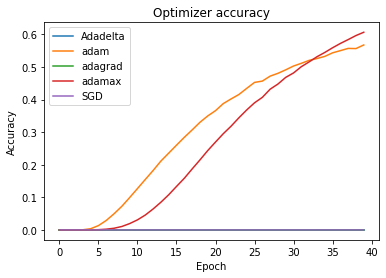

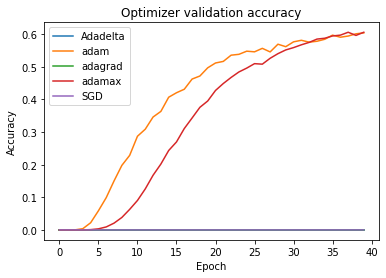

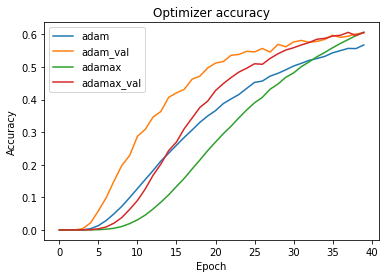

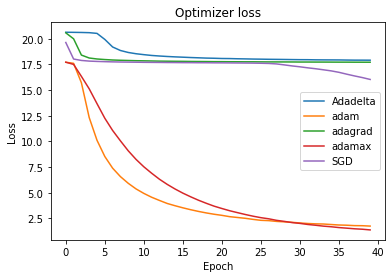

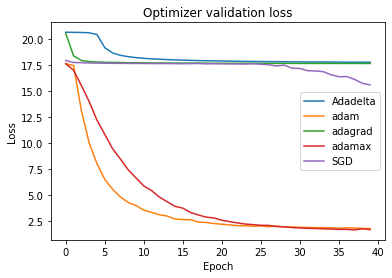

In [107]:
for (hist_acc, _, _,_,n) in results_acc:
    plt.plot(hist_acc, label=n)


    
plt.title('Optimizer accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

for (_, hist_acc_val,_,_, n) in results_acc:
    plt.plot(hist_acc_val, label=n)
    
plt.title('Optimizer validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


for (hist_acc, hist_acc_val,_,_, n) in results_acc:
    if(n == 'adam' or n == 'adamax'):
        plt.plot(hist_acc, label=n)
        plt.plot(hist_acc_val, label=n+"_val")


    
plt.title('Optimizer accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()



for (_, _, hist_loss ,_, n) in results_acc:
        plt.plot(hist_loss, label=n)


    
plt.title('Optimizer loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()



for (_, _, _ ,hist__val_loss, n) in results_acc:
        plt.plot(hist__val_loss, label=n)


    
plt.title('Optimizer validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()




In [106]:
# Trained_model_vg16_kag,name_vg16_kag, hist_vg16_kag = TrainModel(ModelVGG16((25, 67, 1)), x_trainKaggle, s_trainKaggle, x_testKaggle, s_testKaggle )

In [94]:
# modelCifar=load_model("saved_models/keras_Cifar10_trained_model.h5")
# # EvaluateScore(modelCifar)

In [95]:
# modelLeNet=load_model("saved_models/keras_LeNet_trained_model.h5")
# EvaluateScore(modelLeNet)